# Deep Learning: LLM: Classification Finetuning
**Thomas Bohn**   --   **2025-09-30**

{{xxxxx}}  

--  [Main Report](https://github.com/TOM-BOHN/MsDS-deep-learning-llm-classification-finetuning/blob/main/deep-learning-llm-classification-finetuning.ipynb)  --  [Github Repo](https://github.com/TOM-BOHN/MsDS-deep-learning-llm-classification-finetuning)  --  [Presentation Slides](xxx)  --  [Presentation Video](xxx) --  

# 1.&nbsp;Introduction

**Problem Statement**

This project addresses the challenge of predicting which responses users will prefer in a head-to-head comparison between chatbots powered by large language models (LLMs). The core problem involves developing machine learning models that can accurately predict human preferences when comparing responses from different LLMs to the same prompts. This is fundamentally a classification problem where we must determine whether users will prefer model A's response, model B's response, or consider them tied, based on the prompt and both responses.

**Why is it Important?**

As large language models (LLMs) become increasingly integrated into our daily lives, ensuring their responses resonate with users is critical for successful human-AI interaction. The ability to predict user preferences has profound implications for developing more user-friendly AI systems, improving chatbot interactions, and advancing the field of reinforcement learning from human feedback (RLHF). This work directly contributes to creating AI systems that can better align with human values and preferences, ultimately leading to more widely accepted and effective AI-powered conversation systems.

**Limitations of Existing Solutions**

Current approaches to preference prediction face several significant limitations. Direct prompting of existing LLMs for preference predictions often suffers from systematic biases, including position bias (favoring responses presented first), verbosity bias (preferring overly verbose responses), and self-enhancement bias (models promoting their own responses). Additionally, traditional methods struggle with the nuanced understanding required to evaluate response quality across diverse conversation contexts and user preferences. These limitations highlight the need for specialized machine learning approaches that can learn from human preference data rather than relying on model introspection.

**Contribution**

This project contributes to the field by developing and evaluating multiple machine learning approaches for LLM preference prediction, including baseline supervised learning models, hyperparameter optimization, and advanced classification techniques. The work provides a comprehensive comparison of different methodologies on real-world preference data from the Chatbot Arena, offering insights into which approaches work best for this challenging classification task. The project also demonstrates practical implementation strategies for handling large-scale text classification problems with imbalanced datasets.

**Related Kaggle Competition**

[LLM Classification Finetuning](https://www.kaggle.com/competitions/llm-classification-finetuning/overview)

**DataSet**

The dataset consists of user interactions from the Chatbot Arena, containing approximately 55,000 training examples and 25,000 test examples. Each interaction includes a user prompt, responses from two different LLMs (model A and model B), and human judge preferences indicating which response was preferred or if they were considered tied. The dataset represents real-world human preferences across diverse conversation topics and response styles, providing a rich foundation for developing preference prediction models. The text data may contain profane, vulgar, or offensive content, reflecting the authentic nature of human-AI interactions in the wild.

**Data Facts**

- **Dataset Size**:
  - ~55,000 training examples
  - ~25,000 test examples
  - 184.19 MB
- **Features**:
  - `id`: Unique identifier for each row
  - `prompt`: User input given to both models
  - `response_a`: Response from model A
  - `response_b`: Response from model B
  - `model_a`/`model_b`: Model identities (training only)
  - `winner_model_a`/`winner_model_b`/`winner_tie`: Binary target columns
- **Task**: Multi-class classification (3 classes: model A wins, model B wins, tie)
- **Data Source**: Chatbot Arena user interactions with human judge preferences
- **Content Warning**: Contains potentially profane, vulgar, or offensive text
- **Evaluation Metric**: Log loss with "eps=auto" for probability predictions


## Overview of Approach

{{xxxxxx}}

## Detect Environment

Determine if the notebook is running in Colab or Kaggle. Then change how the notebook behaves.

In [1]:
# Detect Environment
import os
gIS_COLAB = 'COLAB_GPU' in os.environ or 'COLAB_TPU' in os.environ or 'COLAB_CPU' in os.environ
gIS_KAGGLE = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ
print("Is Kaggle?", gIS_KAGGLE, " | ", "Is Colab?", gIS_COLAB)

Is Kaggle? False  |  Is Colab? True


## Add Colab Only Libraries


In [2]:
# Install the necessary packages
import os
if gIS_COLAB:
    # Install Colab Specific Tooling
    from google.colab import userdata
    from google.colab import files

    # Mount the Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Install the necessary packages
    !pip install -q tensorflow
    !pip install -q kaggle

Mounted at /content/drive


## Add Kaggle Only Libraries

In [3]:
# Install the necessary packages
if gIS_KAGGLE:
    from kaggle_datasets import KaggleDatasets

## Common Python Libraries

The following python libraries are used in this notebook.

In [4]:
# File system manangement
import time, datetime, psutil, os
import shutil
import zipfile

# Data manipulation
import numpy as np
import pandas as pd
import math
import random

# Install text storage and manipulation
import re
import json
import pickle
import textwrap
from tqdm import tqdm

##################################

# Plotting and visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px
import seaborn as sns
sns.set_theme()

# Train-test split and cross validation
from sklearn.model_selection import train_test_split, ParameterGrid

# Model evaluation
from sklearn import metrics
# Model Evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    accuracy_score
)

# Import Tensor Flow and Keras
import tensorflow as tf
from tensorflow import keras
import keras_nlp
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, History

##################################

os.environ["KERAS_BACKEND"] = "jax"  # or "tensorflow" or "torch"

##################################

print(f'Keras: {keras.__version__}')
print(f'KerasNLP: {keras_nlp.__version__}')
print(f'Tensorflow: {tf.__version__}')

##################################

# Suppress SyntaxWarnings for invalid escape sequences
import warnings
warnings.filterwarnings('ignore', category=SyntaxWarning, message='invalid escape sequence')

Keras: 3.10.0
KerasNLP: 0.21.1
Tensorflow: 2.19.0


In [5]:
# Memory monitoring and cleanup functions
def get_memory_usage():
    """Get current memory usage in MB"""
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()
    return memory_info.rss / 1024 / 1024  # Convert to MB

def print_memory_usage(stage=""):
    """Print current memory usage"""
    memory_mb = get_memory_usage()
    print(f"Memory usage {stage}: {memory_mb:.1f} MB")

def cleanup_memory():
    """Clean up memory by clearing TensorFlow cache and running garbage collection"""
    import gc
    # Clear TensorFlow cache
    tf.keras.backend.clear_session()
    # Force garbage collection
    gc.collect()
    print("Memory cleaned up")

def clear_session_between_models():
    """Clear TensorFlow session between model experiments to avoid variable conflicts"""
    import gc
    # Clear TensorFlow session and cache
    tf.keras.backend.clear_session()
    # Force garbage collection
    gc.collect()
    print("Session cleared - ready for next model experiment")

# Print initial memory usage
print_memory_usage("at startup")

Memory usage at startup: 840.4 MB


## Connect to TPUs

In [6]:
# TPU (Tensor Processing Unit) Setup for Accelerated Training
# This code attempts to connect to Google's TPU infrastructure for faster model training
# TPUs are specialized hardware designed specifically for machine learning workloads

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('✅ TPU found:', tpu.master())
except:
    print("❌ No TPU found. Falling back to CPU/GPU.")
    tpu = None

if tpu:
    # Connect to the TPU cluster.
    tf.config.experimental_connect_to_cluster(tpu)
    # Initialize the TPU system for use
    tf.tpu.experimental.initialize_tpu_system(tpu)
    # Create a TPU distribution strategy for multi-core TPU usage
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Use the default strategy for CPU/GPU.
    strategy = tf.distribute.get_strategy()

# Print the number of replicas (cores) available for parallel processing
print('Number of replicas:', strategy.num_replicas_in_sync)

# Set up automatic tuning for data pipeline performance optimization
# AUTOTUNE allows TensorFlow to automatically determine the optimal number of parallel calls
AUTOTUNE = tf.data.AUTOTUNE

# Print TensorFlow version for reference
print("TensorFlow version:", tf.__version__)

❌ No TPU found. Falling back to CPU/GPU.
Number of replicas: 1
TensorFlow version: 2.19.0


## Connect to GPUs

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.gpu_device_name())

# Configure GPU memory growth (prevents OOM errors)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1
/device:GPU:0


## Global Variables

The following are global variables referenced in this notebook.

In [8]:
# Recording the starting time, complemented with a stopping time check in the end to compute process runtime
start = time.time()

# Class representing the OS process and having memory_info() method to compute process memory usage
process = psutil.Process(os.getpid())

In [9]:
# Global Debug flag used to turn on and off more chatty blocks of code
gDEBUG = True
print('Debug is set to:', gDEBUG)
# Global Level of Detail of table stats and details
gLOD = 2
print('Level of Detail for functions is set to:', gLOD)

# Use environment global variables
gIS_COLAB = gIS_COLAB
gIS_KAGGLE = gIS_KAGGLE
print("Is Kaggle?", gIS_KAGGLE, " | ", "Is Colab?", gIS_COLAB)

Debug is set to: True
Level of Detail for functions is set to: 2
Is Kaggle? False  |  Is Colab? True


## Notebook Configuration

The following class consolidates key model configuration into an early cell to allow for easy access and adjustment.

In [99]:
class CFG:
    """
    Configuration class for LLM Classification Finetuning project.
    Organizes parameters by model type: baseline, experiments 1-3, and final design.
    Models use baseline parameters unless overridden by model-specific parameters.
    """

    # =============================================================================
    # GLOBAL CONFIGURATION PARAMETERS
    # =============================================================================
    seed = 27  # Random seed for reproducibility
    sample_frac = 1  # Fraction of data to sample for development (0.1 = 10%)

    # =============================================================================
    # BASELINE MODEL CONFIGURATION (Model 0: Baseline)
    # =============================================================================
    # DeBERTa v3 Components - Default Architecture
    preset = "deberta_v3_extra_small_en"  # Name of pretrained DeBERTa model
    preprocessor = keras_nlp.models.DebertaV3Preprocessor  # Text preprocessor
    backbone = keras_nlp.models.DebertaV3Backbone  # Model backbone architecture
    optimizer = keras.optimizers.Adam(5e-6)  # Adam optimizer with very low learning rate
    # These parameters are used by the baseline model and serve as defaults
    sequence_length = 512  # Input sequence length (tokens)
    epochs = 10  # Training epochs
    batch_size = 8  # Batch size for training
    scheduler = 'cosine'  # Learning rate scheduler type

    # =============================================================================
    # EXPERIMENT 1 CONFIGURATION (Model 1: AdamW Optimizer)
    # =============================================================================
    # Uses baseline parameters with AdamW optimizer instead of Adam
    preset_1 = "deberta_v3_extra_small_en"  # Name of pretrained DeBERTa model
    preprocessor_1 = keras_nlp.models.DebertaV3Preprocessor  # Text preprocessor
    backbone_1 = keras_nlp.models.DebertaV3Backbone  # Model backbone architecture
    optimizer_1 = keras.optimizers.AdamW(5e-6, weight_decay=0.01)  # Adam optimizer with very low learning rate


    # =============================================================================
    # EXPERIMENT 2 CONFIGURATION (Model 2: Larger Context)
    # =============================================================================
    # Uses a larger DeBERTa v3 model with extended context window (1K+ tokens)
    preset_2 = "deberta_v3_small_en"  # Larger model variant for extended context
    preprocessor_2 = keras_nlp.models.DebertaV3Preprocessor  # Text preprocessor
    backbone_2 = keras_nlp.models.DebertaV3Backbone  # Model backbone architecture
    optimizer_2 = keras.optimizers.Adam(5e-6)  # Adam optimizer with very low learning rate

    sequence_length_2 = 1024  # Extended sequence length for larger context window
    batch_size_2 = 4  # Reduced batch size due to increased memory requirements

    # =============================================================================
    # EXPERIMENT 3 CONFIGURATION (Model 3: Enhanced Architecture)
    # =============================================================================

    preset_3 = "deberta_v3_extra_small_en"  # Name of pretrained DeBERTa model
    preprocessor_3 = keras_nlp.models.DebertaV3Preprocessor  # Text preprocessor
    backbone_3 = keras_nlp.models.DebertaV3Backbone  # Model backbone architecture
    optimizer_3 = keras.optimizers.Adam(5e-6)  # Adam optimizer with very low learning rate

    # Enhanced model architecture with multi-layer classification head
    hidden_units_3 = [512, 256, 64]  # Hidden layer sizes
    dropout_rates_3 = [0.3, 0.2, 0.1]  # Dropout rates for each layer
    learning_rate_3 = 1e-5  # Slightly higher learning rate for enhanced model
    batch_size_3 = 8  # Adjusted batch size for enhanced model

    # =============================================================================
    # FINAL DESIGN CONFIGURATION (Model 4: Optimized Final Model)
    # =============================================================================
    # Extended training configuration for the final optimized model
    final__epochs = 10  # Extended epochs for final design model
    final_design_batch_size = 8  # Reduced batch size due to increased memory requirements

    # =============================================================================
    # MODEL TRAINING CONTROL VARIABLES
    # =============================================================================
    # Set to True to enable training, False to skip training for each model
    train_baseline = False         # Model 0: Baseline model
    train_experiment_1 = True    # Model 1: AdamW Optimizer experiment
    train_experiment_2 = False    # Model 2: Larger Context experiment
    train_experiment_3 = False    # Model 3: Enhanced Model Architecture
    train_final_design = False    # Model 4: Final design (may run extended epochs)

    # =============================================================================
    # CLASSIFICATION LABELS CONFIGURATION
    # =============================================================================
    # Mapping between class labels and names for the 3-class classification problem
    label2name = {0: 'winner_model_a', 1: 'winner_model_b', 2: 'winner_tie'}
    name2label = {v: k for k, v in label2name.items()}  # Reverse mapping
    class_labels = list(label2name.keys())  # [0, 1, 2]
    class_names = list(label2name.values())  # ['winner_model_a', 'winner_model_b', 'winner_tie']

In [11]:
print(f'label2name:   {CFG.label2name}')
print(f'name2label:   {CFG.name2label}')
print(f'class_labels: {CFG.class_labels}')
print(f'class_names:  {CFG.class_names}')

print(f'\nTraining Control Variables:')
print(f'train_baseline:      {CFG.train_baseline}')
print(f'train_experiment_1:  {CFG.train_experiment_1}')
print(f'train_experiment_2:  {CFG.train_experiment_2}')
print(f'train_experiment_3:  {CFG.train_experiment_3}')
print(f'train_final_design:  {CFG.train_final_design}')

# Sets value for random seed to produce similar result in each run.
keras.utils.set_random_seed(CFG.seed)
print(f'Keras Random Seed: {CFG.seed}.')

# Decrease Precision to reduce memory usage
keras.mixed_precision.set_global_policy("mixed_float16")
print(f'Mixed Precision: "mixed_float16".')

# Additional memory optimizations
# Limit GPU memory growth to prevent OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to True to allocate memory as needed
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print('GPU memory growth enabled.')
    except RuntimeError as e:
        print(f'GPU memory growth setup failed: {e}')

# Set memory limit for GPU (optional - uncomment if needed)
# tf.config.experimental.set_memory_limit(gpus[0], 4096)  # Limit to 4GB

# Ensure eager execution is enabled to fix numpy() conversion issues
tf.config.run_functions_eagerly(False)
print('Eager execution enabled for all functions.')

# Enable gradient checkpointing to reduce memory usage
# This trades computation for memory by recomputing gradients instead of storing them
tf.config.optimizer.set_jit(True)  # Enable XLA compilation for better performance
print('Gradient checkpointing and XLA compilation enabled for memory optimization.')

label2name:   {0: 'winner_model_a', 1: 'winner_model_b', 2: 'winner_tie'}
name2label:   {'winner_model_a': 0, 'winner_model_b': 1, 'winner_tie': 2}
class_labels: [0, 1, 2]
class_names:  ['winner_model_a', 'winner_model_b', 'winner_tie']

Training Control Variables:
train_baseline:      True
train_experiment_1:  False
train_experiment_2:  False
train_experiment_3:  False
train_final_design:  False
Keras Random Seed: 27.
Mixed Precision: "mixed_float16".
GPU memory growth enabled.
Eager execution enabled for all functions.
Gradient checkpointing and XLA compilation enabled for memory optimization.


# 2.&nbsp;Data Source

In this section, the code loads the dataset from Google Drive.

{{xxxxx}}

## Import the Data (Kaggle or Colab)

In [12]:
#print('os.environ: ', os.environ)

if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    print("Detected Kaggle environment - using Kaggle datasets")
elif 'COLAB_GPU' in os.environ or 'COLAB_TPU' in os.environ or 'COLAB_CPU' in os.environ:
    print("Detected Google Colab environment - using local datasets")
else:
    print("YIKES! I don't know where I am !!!!!!")

Detected Google Colab environment - using local datasets


In [13]:
# Environment Detection and Dataset Loading
# Detect whether we're running in Kaggle or Google Colab and load datasets accordingly

if gIS_KAGGLE:
    print("Detected Kaggle environment - using Kaggle datasets")

    # Dataset Path Configuration for Kaggle Environment
    # This allows access to the competition datasets stored in Kaggle's cloud storage
    GCS_PATH = '/kaggle/input/llm-classification-finetuning'

    # Load Dataset for train
    train_path = os.path.join(GCS_PATH, 'train.csv')
    train_df = pd.read_csv(train_path)
    print('Train Dataset Size:', len(train_df))

    # Load Dataset for test
    test_path = os.path.join(GCS_PATH, 'test.csv')
    test_df = pd.read_csv(test_path)
    print('Test Dataset Size:', len(test_df))

elif gIS_COLAB:
    print("Detected Google Colab environment - using local datasets")

    # Define the source of the zipped data files
    target_file = 'llm-classification-finetuning.zip'
    source_path_root = '/content/drive/MyDrive/[1.4] MsDS Class Files/-- DTSA 5511 Deep Learning/data'
    destination_path_root = '/content'

    # Copy the files to the runtime
    shutil.copy(source_path_root + '/' + target_file, destination_path_root + '/')

    # Display the files in the destination directory
    print('Files in destination directory:', os.listdir(destination_path_root + '/'))

    # Unzip the files (this is slow)
    zip_file_path = destination_path_root + '/' + target_file

    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all the contents into the specified folder
        zip_ref.extractall(destination_path_root + '/' + 'llm-classification-finetuning')

    print('Dataset extraction completed')

    # Dataset Path Configuration for Google Colab Environment
    # Set up local file paths for the extracted dataset files
    COLAB_DATA_PATH = '/content/llm-classification-finetuning'

    # Load Dataset for train
    train_path = os.path.join(COLAB_DATA_PATH, 'train.csv')
    train_df = pd.read_csv(train_path)
    print('Train Dataset Size:', len(train_df))

    # Load Dataset for test
    test_path = os.path.join(COLAB_DATA_PATH, 'test.csv')
    test_df = pd.read_csv(test_path)
    print('Test Dataset Size:', len(test_df))

else:
    print("YIKES! I don't know where I am !!!!!!")

# Verify the datasets are loaded correctly
if len(train_df) > 0:
    print(f"Successfully loaded {len(train_df)} training records")
else:
    print("No training files found. Check the dataset path.")

if len(test_df) > 0:
    print(f"Successfully loaded {len(test_df)} test records")
else:
    print("No test files found. Check the dataset path.")


Detected Google Colab environment - using local datasets
Files in destination directory: ['.config', 'drive', 'llm-classification-finetuning.zip', 'sample_data']
Dataset extraction completed
Train Dataset Size: 57477
Test Dataset Size: 3
Successfully loaded 57477 training records
Successfully loaded 3 test records


## Data Preparation

In [14]:
# Display the first record (index 0)
print("="*80)
print("FIRST RECORD (Index 0) - ORIGINAL DATA:")
print("="*80)
print("Original prompt:", train_df['prompt'].iloc[0])
print("\nOriginal response_a:", train_df['response_a'].iloc[0])
print("\nOriginal response_b:", train_df['response_b'].iloc[0])

FIRST RECORD (Index 0) - ORIGINAL DATA:
Original prompt: ["Is it morally right to try to have a certain percentage of females on managerial positions?","OK, does pineapple belong on a pizza? Relax and give me fun answer."]

Original response_a: ["The question of whether it is morally right to aim for a certain percentage of females in managerial positions is a complex ethical issue that involves considerations of fairness, equality, diversity, and discrimination.\n\nHere are some arguments in favor of and against such policies:\n\n**Arguments in favor:**\n\n1. **Correcting Historical Inequities:** Women have historically been underrepresented in leadership roles due to various cultural, institutional, and social barriers. Aiming for a specific percentage can be seen as a corrective measure to address past and ongoing discrimination.\n\n2. **Promoting Diversity:** Diverse leadership teams can enhance decision-making and represent a broader range of perspectives. This can lead to better 

In [15]:
def clean_and_extract_text(raw_data_string):
    try:
        # and handle null values by replacing them with None
        safe_dict = {'null': None}

        # Replace 'null' with None in the string before evaluation
        safe_string = raw_data_string.replace('null', 'None')

        # Use eval with a safer approach - only allow specific built-ins
        evaluated_list = eval(safe_string, {"__builtins__": {}}, safe_dict)

        cleaned_list = []
        for raw_str in evaluated_list:
            # Handle None values (which represent null in the original data)
            if raw_str is None:
                cleaned_list.append("")
                continue

            # Clean the string and handle escape sequences
            cleaned_str = str(raw_str)
            # Fix common escape sequence issues that cause SyntaxWarnings
            cleaned_str = cleaned_str.replace('\\/', '/')  # Fix \/ to /
            cleaned_str = cleaned_str.replace('\\n', '\n')  # Fix \n to newline
            cleaned_str = cleaned_str.replace('\\t', '\t')  # Fix \t to tab

            # Encode and decode to handle potential malformed characters
            encoded_bytes = cleaned_str.encode('utf-8', errors='ignore')
            decoded_str = encoded_bytes.decode('utf-8', errors='ignore')
            cleaned_list.append(decoded_str)

        # Return the first item, or an empty string if the list is empty
        return cleaned_list[0] if cleaned_list else ""

    except:
        # Fallback for any parsing errors - return the original string cleaned
        try:
            # If it's not a list representation, just clean the string directly
            cleaned_str = str(raw_data_string)
            # Fix common escape sequence issues
            cleaned_str = cleaned_str.replace('\\/', '/')  # Fix \/ to /
            cleaned_str = cleaned_str.replace('\\n', '\n')  # Fix \n to newline
            cleaned_str = cleaned_str.replace('\\t', '\t')  # Fix \t to tab

            # If it's not a list representation, just clean the string directly
            encoded_bytes = cleaned_str.encode('utf-8', errors='ignore')
            decoded_str = encoded_bytes.decode('utf-8', errors='ignore')
            return decoded_str
        except:
            return ""

def process_competition_data(input_df, label_map, sample_frac=None):

    # Work on a copy to avoid modifying the original DataFrame in place
    df = input_df.copy()

    # Optionally sample the data to speed up development
    if sample_frac:
        df = df.sample(frac=sample_frac, random_state=1) # Using a random_state for consistent results

    # List of all input text columns in the dataset to clean
    input_cols = ["prompt", "response_a", "response_b"]

    # Process each column with the same cleaning function
    for col in input_cols:
        if col in df.columns:
            new_col_name = col + "_clean"
            df[new_col_name] = df[col].map(clean_and_extract_text)

    # List of all winner values columns in the dataset
    winner_cols = ["winner_model_a", "winner_model_b", "winner_tie"]

    # Check if all required winner columns exist
    if all(col in df.columns for col in winner_cols):
        # Check if a label_map was provided, which is now necessary
        if not label_map:
            raise ValueError("Input DataFrame has winner columns, but no 'label_map' was provided.")
        # Create the new class label columns
        df["class_name"] = df[winner_cols].idxmax(axis=1)
        df["class_label"] = df['class_name'].map(label_map)
    else:
        print("Winner columns not found. Skipping label creation.")

    return df

In [16]:
# Process the training data
train_p_df = process_competition_data(
    input_df=train_df,
    label_map=CFG.name2label,
    sample_frac=CFG.sample_frac
)

# Show Sample
print("Training data processed:")
print(f"Shape: {train_p_df.shape}")
print(f"Columns: {list(train_p_df.columns)}")
train_p_df.head()

Training data processed:
Shape: (57477, 14)
Columns: ['id', 'model_a', 'model_b', 'prompt', 'response_a', 'response_b', 'winner_model_a', 'winner_model_b', 'winner_tie', 'prompt_clean', 'response_a_clean', 'response_b_clean', 'class_name', 'class_label']


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,prompt_clean,response_a_clean,response_b_clean,class_name,class_label
20371,1517001334,claude-2.0,wizardlm-70b,"[""Hi, i have a weird problem with the data pro...","[""There are a few possible reasons why the fil...","[""There could be several reasons for the drop ...",0,1,0,"Hi, i have a weird problem with the data proce...",There are a few possible reasons why the file ...,There could be several reasons for the drop in...,winner_model_b,1
11955,885613987,palm-2,llama-2-13b-chat,"[""what are the benefits of a private sale of r...","[""There are a number of benefits to a private ...","[""Hello! I'm happy to help answer your questio...",0,0,1,what are the benefits of a private sale of rea...,There are a number of benefits to a private sa...,Hello! I'm happy to help answer your question ...,winner_tie,2
852,62077669,gpt-3.5-turbo-0125,openchat-3.5-0106,"[""What do you think of Shakespeare's Richard I...","[""\""Richard II\"" is considered one of Shakespe...","[""Shakespeare's \""Richard II\"" is a complex an...",0,1,0,What do you think of Shakespeare's Richard II?,"""Richard II"" is considered one of Shakespeare'...","Shakespeare's ""Richard II"" is a complex and th...",winner_model_b,1
6321,473766316,vicuna-33b,codellama-34b-instruct,"[""Is it true that Westboro Baptist Church prai...","[""Yes, it is true that the Westboro Baptist Ch...","[""Yes, it is true that Westboro Baptist Church...",0,1,0,Is it true that Westboro Baptist Church praise...,"Yes, it is true that the Westboro Baptist Chur...","Yes, it is true that Westboro Baptist Church, ...",winner_model_b,1
42140,3135597227,zephyr-7b-beta,llama-2-13b-chat,"[""Could you assign percentage classifications ...","[""| Firm |...","[""Sure! Here are the percentage classification...",1,0,0,Could you assign percentage classifications fo...,| Firm | P...,Sure! Here are the percentage classifications ...,winner_model_a,0


In [17]:
# Process the testing data
test_p_df = process_competition_data(
    input_df=test_df,
    label_map=CFG.name2label,
    sample_frac=1
)

# Show Sample
print("Testing data processed:")
print(f"Shape: {test_p_df.shape}")
print(f"Columns: {list(test_p_df.columns)}")
test_p_df.head()

Winner columns not found. Skipping label creation.
Testing data processed:
Shape: (3, 7)
Columns: ['id', 'prompt', 'response_a', 'response_b', 'prompt_clean', 'response_a_clean', 'response_b_clean']


,id,prompt,response_a,response_b,prompt_clean,response_a_clean,response_b_clean
0,136060,"[""I have three oranges today, I ate an orange ...","[""You have two oranges today.""]","[""You still have three oranges. Eating an oran...","I have three oranges today, I ate an orange ye...",You have two oranges today.,You still have three oranges. Eating an orange...
2,1233961,"[""How to initialize the classification head wh...","[""When you want to initialize the classificati...","[""To initialize the classification head when p...",How to initialize the classification head when...,When you want to initialize the classification...,To initialize the classification head when per...
1,211333,"[""You are a mediator in a heated political deb...","[""Thank you for sharing the details of the sit...","[""Mr Reddy and Ms Blue both have valid points ...",You are a mediator in a heated political debat...,Thank you for sharing the details of the situa...,Mr Reddy and Ms Blue both have valid points in...


## Preview Results of Data  Prep

In [18]:
# Display the first record (index 0)
print("="*80)
print("FIRST RECORD (Index 0) - ORIGINAL DATA:")
print("="*80)
print("Original prompt:", train_p_df['prompt'].iloc[0])
print("\nOriginal response_a:", train_p_df['response_a'].iloc[0])
print("\nOriginal response_b:", train_p_df['response_b'].iloc[0])

print("\n" + "="*80)
print("FIRST RECORD (Index 0) - CLEANED DATA:")
print("="*80)
print("Cleaned prompt:", train_p_df['prompt_clean'].iloc[0])
print("\nCleaned response_a:", train_p_df['response_a_clean'].iloc[0])
print("\nCleaned response_b:", train_p_df['response_b_clean'].iloc[0])


FIRST RECORD (Index 0) - ORIGINAL DATA:
Original prompt: ["Hi, i have a weird problem with the data processing i'm currently doing. I have a huge amount of large files on disk that need to be scanned. In comparison the result is only a small file that gets written at the end. I'm also far from full CPU or memory usage. The bottleneck is the speed at which my program can access\/read the files on disk. My problem is that this read speed, although it starts at about 50mb\/s somehow drops to only 3-5mb\/s after a few minutes. Why would this happen?"]

Original response_a: ["There are a few possible reasons why the file read speed could drop over time when processing large amounts of data from disk:\n\n- Disk caching effects - When first starting to read files, the operating system caches some of the file contents in memory for faster access. As more data is read, the cache gets filled up and disk reads go back to normal slower speeds.\n\n- Disk fragmentation - If the files are fragmented 

# 3.&nbsp;Exploratory Data Analysis (EDA)

The EDA phase focuses on understanding the dataset, including data distribution and label counts. Various functions are used to inspect the structure of the dataset, visualize the label distribution, and assess the text length and word count of the documentation. The data is found to be somewhat imbalanced across categories.

## EDA Functions

In [19]:
def add_text_analysis_columns(df, text_column):
    # Create a copy to avoid modifying the original dataframe
    result_df = df.copy()

    # Add character length column
    length_col = f"{text_column}_length"
    result_df[length_col] = result_df[text_column].astype(str).str.len()

    # Add word count column
    word_count_col = f"{text_column}_word_count"
    result_df[word_count_col] = result_df[text_column].astype(str).str.split().str.len()

    # Add estimated tokens column (rough approximation: ~4 characters per token)
    tokens_col = f"{text_column}_estimated_tokens"
    result_df[tokens_col] = (result_df[length_col] / 4).round().astype(int)

    return result_df

In [20]:
# Preview Sample Records in Train
def preview_random_record(df, show_columns=None):
    # Set random seed for reproducibility
    random.seed(27)

    # Select a random index
    random_idx = random.randint(0, len(df) - 1)
    random_record = df.iloc[random_idx]

    # Default columns to show if not specified
    if show_columns is None:
        show_columns = ['id', 'prompt_clean', 'response_a_clean', 'response_b_clean',
                       'model_a', 'model_b', 'class_name', 'class_label']

    print(f"Random Record Preview (Index: {random_idx})")
    print("=" * 80)

    # Display each column with proper formatting
    for col in show_columns:
        if col in df.columns:
            value = random_record[col]

            # Format text columns with word wrapping
            if col in ['prompt_clean', 'response_a_clean', 'response_b_clean']:
                print(f"\n🔹 {col.upper()}:")
                print("-" * 40)
                # Wrap text for better readability
                wrapped_text = textwrap.fill(str(value), width=70, initial_indent="  ", subsequent_indent="  ")
                print(wrapped_text)
            else:
                print(f"\n🔹 {col.upper()}: {value}")

    print("\n" + "=" * 80)
    print(f"Record Statistics:")
    print(f"   - Prompt Word Count: {random_record['prompt_clean_word_count']} words")
    print(f"   - Response A Word Count: {random_record['response_a_clean_word_count']} words")
    print(f"   - Response B Word Count: {random_record['response_b_clean_word_count']} words")
    print(f"   - Prompt Estimated Tokens: {random_record['prompt_clean_estimated_tokens']} words")
    print(f"   - Response A Estimated Tokens: {random_record['response_a_clean_estimated_tokens']} words")
    print(f"   - Response B Estimated Tokens: {random_record['response_b_clean_estimated_tokens']} words")
    return random_record

In [21]:
def plot_llm_distribution(df, model_a_col='model_a', model_b_col='model_b',
                         title='Distribution of LLMs',
                         color_scale='viridis',
                         x_axis_rotation=-45,
                         fig_width=None, fig_height=None):

    # Combine model columns and count occurrences
    model_df = pd.concat([df[model_a_col], df[model_b_col]])
    counts = model_df.value_counts().reset_index()
    counts.columns = ['LLM', 'Count']

    # Create the bar plot
    fig = px.bar(counts, x='LLM', y='Count',
                 title=title,
                 color='Count',
                 color_continuous_scale=color_scale)

    # Update layout for better readability
    fig.update_layout(
        xaxis_tickangle=x_axis_rotation,
        width=fig_width,
        height=fig_height
    )

    return fig

In [22]:
def plot_winner_distribution(df, class_name_col='class_name',
                           title='Winner Distribution',
                           color_scale='viridis',
                           fig_width=None, fig_height=None,
                           show_values=True):

    # Count occurrences of each winner class
    counts = df[class_name_col].value_counts().reset_index()
    counts.columns = ['Winner', 'Win Count']

    # Create the bar plot
    fig = px.bar(counts, x='Winner', y='Win Count',
                 title=title,
                 labels={'Winner': 'Winner', 'Win Count': 'Win Count'},
                 color='Winner',
                 color_continuous_scale=color_scale)

    # Update layout
    fig.update_layout(
        xaxis_title="Winner",
        yaxis_title="Win Count",
        width=fig_width,
        height=fig_height
    )

    # Add count values on top of bars if requested
    if show_values:
        fig.update_traces(texttemplate='%{y}', textposition='outside')

    return fig

In [23]:
# Common distribution function for word count + other stats visualizations
def plot_word_count_distribution(df, column_name, title, fig_width=800, fig_height=500,
                                bins=50, color='skyblue', show_stats=True):
    # Get the data
    data = df[column_name].dropna()

    # Create the figure
    fig, ax = plt.subplots(figsize=(fig_width/100, fig_height/100))

    # Create histogram
    n, bins_edges, patches = ax.hist(data, bins=bins, color=color, alpha=0.7, edgecolor='black', linewidth=0.5)

    # Add statistics if requested
    if show_stats:
        mean_val = data.mean()
        median_val = data.median()
        std_val = data.std()

        # Add vertical lines for mean and median
        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
        ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.1f}')

        # Add text box with statistics
        stats_text = f'Count: {len(data):,}\nMean: {mean_val:.1f}\nMedian: {median_val:.1f}\nStd: {std_val:.1f}\nMin: {data.min():.1f}\nMax: {data.max():.1f}'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

        ax.legend()

    # Customize the plot
    ax.set_xlabel('Word Count', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Format x-axis to show integer values
    ax.ticklabel_format(style='plain', axis='x')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(f"\n{title} - Summary Statistics:")
    print(f"Count: {len(data):,}")
    print(f"Mean: {data.mean():.2f}")
    print(f"Median: {data.median():.2f}")
    print(f"Standard Deviation: {data.std():.2f}")
    print(f"Minimum: {data.min():.0f}")
    print(f"Maximum: {data.max():.0f}")
    print(f"25th Percentile: {data.quantile(0.25):.2f}")
    print(f"75th Percentile: {data.quantile(0.75):.2f}")

    return fig

## EDA Analysis: Overview

In [24]:
# Apply the function to analyze the prompt column
train_ps_df = add_text_analysis_columns(train_p_df, 'prompt_clean')
train_ps_df = add_text_analysis_columns(train_ps_df, 'response_a_clean')
train_ps_df = add_text_analysis_columns(train_ps_df, 'response_b_clean')

test_ps_df = add_text_analysis_columns(test_p_df, 'prompt_clean')
test_ps_df = add_text_analysis_columns(test_ps_df, 'response_a_clean')
test_ps_df = add_text_analysis_columns(test_ps_df, 'response_b_clean')

# Create total words column by summing prompt + response_a + response_b word counts
train_ps_df['total_word_count'] = (
    train_ps_df['prompt_clean_word_count'] +
    train_ps_df['response_a_clean_word_count'] +
    train_ps_df['response_b_clean_word_count']
)

# Create total token estimation column by summing prompt + response_a + response_b word counts
train_ps_df['total_estimated_tokens'] = (
    train_ps_df['prompt_clean_estimated_tokens'] +
    train_ps_df['response_a_clean_estimated_tokens'] +
    train_ps_df['response_b_clean_estimated_tokens']
)

# Create total words column by summing prompt + response_a + response_b word counts
test_ps_df['total_word_count'] = (
    test_ps_df['prompt_clean_word_count'] +
    test_ps_df['response_a_clean_word_count'] +
    test_ps_df['response_b_clean_word_count']
)

# Create total token estimation column by summing prompt + response_a + response_b word counts
test_ps_df['total_estimated_tokens'] = (
    test_ps_df['prompt_clean_estimated_tokens'] +
    test_ps_df['response_a_clean_estimated_tokens'] +
    test_ps_df['response_b_clean_estimated_tokens']
)

train_ps_stats = train_ps_df[[
    'prompt_clean_estimated_tokens',
    'response_a_clean_estimated_tokens',
    'response_b_clean_estimated_tokens',
    'total_estimated_tokens',
    'prompt_clean_word_count',
    'response_a_clean_word_count',
    'response_b_clean_word_count',
    'total_word_count'
]].describe()

train_ps_stats.round(0)

,prompt_clean_estimated_tokens,response_a_clean_estimated_tokens,response_b_clean_estimated_tokens,total_estimated_tokens,prompt_clean_word_count,response_a_clean_word_count,response_b_clean_word_count,total_word_count
count,57477.0,57477.0,57477.0,57477.0,57477.0,57477.0,57477.0,57477.0
mean,79.0,268.0,270.0,617.0,50.0,172.0,173.0,395.0
std,234.0,220.0,222.0,489.0,139.0,136.0,136.0,295.0
min,1.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0
25%,11.0,85.0,86.0,256.0,8.0,57.0,58.0,174.0
50%,20.0,228.0,230.0,532.0,14.0,150.0,151.0,350.0
75%,48.0,402.0,405.0,860.0,34.0,257.0,259.0,550.0
max,3000.0,2028.0,5361.0,5774.0,2464.0,1313.0,1975.0,3523.0


In [25]:
# Display a random record from the training data with word counts
random_record = preview_random_record(train_ps_df)

Random Record Preview (Index: 42499)

🔹 ID: 73710468

🔹 PROMPT_CLEAN:
----------------------------------------
  in chess, how many knights can there be including promotions

🔹 RESPONSE_A_CLEAN:
----------------------------------------
  In chess, there can be a maximum of 10 knights on the board at any
  time, including knights that were promoted from pawns.  Here is the
  breakdown:  • Each player starts with 2 knights. So initially there
  are 4 knights on the board.  • During the game, each player can
  promote a maximum of 2 pawns to knights (1 pawn from each side can
  be promoted if it reaches the opposite side). So through promotion,
  4 additional knights can be added.  • Captured knights are removed
  from the board. So at any point in time, the total number of knights
  on the board for both players cannot exceed the initial 4 plus the
  maximum of 4 that can be added through promotion.  • In theory, it
  is possible for all 8 pawns to be promoted to knights, but that
  woul

In [26]:
# Display a random record from the training data with word counts
random_record = preview_random_record(train_ps_df)

Random Record Preview (Index: 42499)

🔹 ID: 73710468

🔹 PROMPT_CLEAN:
----------------------------------------
  in chess, how many knights can there be including promotions

🔹 RESPONSE_A_CLEAN:
----------------------------------------
  In chess, there can be a maximum of 10 knights on the board at any
  time, including knights that were promoted from pawns.  Here is the
  breakdown:  • Each player starts with 2 knights. So initially there
  are 4 knights on the board.  • During the game, each player can
  promote a maximum of 2 pawns to knights (1 pawn from each side can
  be promoted if it reaches the opposite side). So through promotion,
  4 additional knights can be added.  • Captured knights are removed
  from the board. So at any point in time, the total number of knights
  on the board for both players cannot exceed the initial 4 plus the
  maximum of 4 that can be added through promotion.  • In theory, it
  is possible for all 8 pawns to be promoted to knights, but that
  woul

## EDA Analysis: Text Distribution

In [27]:
# LLM Dostribution in Training
fig = plot_llm_distribution(
    df = train_ps_df,
    model_a_col='model_a',
    model_b_col='model_b',
    title='Training Data: LLM Distribution',
    fig_width=800, fig_height=500
)
fig.show()

In [28]:
# Train Data Winner Distribution
fig = plot_winner_distribution(
    df = train_p_df,
    title='Training Data: Winner Distribution',
    color_scale='plasma',
    fig_width=800, fig_height=500
)
fig.show()

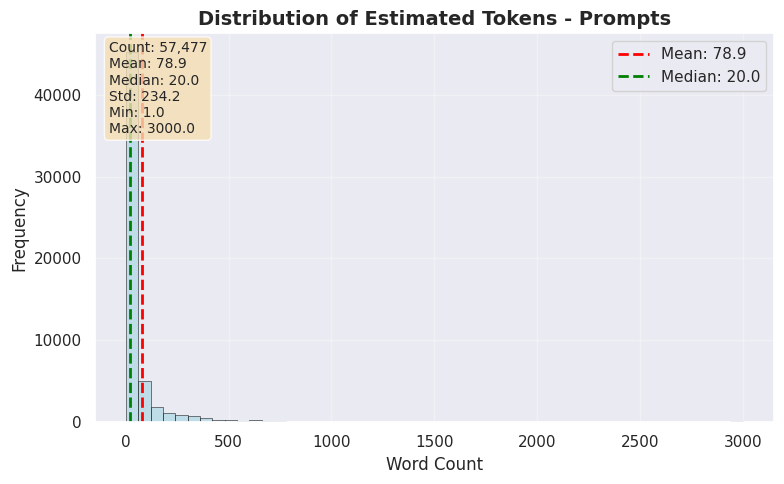


Distribution of Estimated Tokens - Prompts - Summary Statistics:
Count: 57,477
Mean: 78.94
Median: 20.00
Standard Deviation: 234.21
Minimum: 1
Maximum: 3000
25th Percentile: 11.00
75th Percentile: 48.00


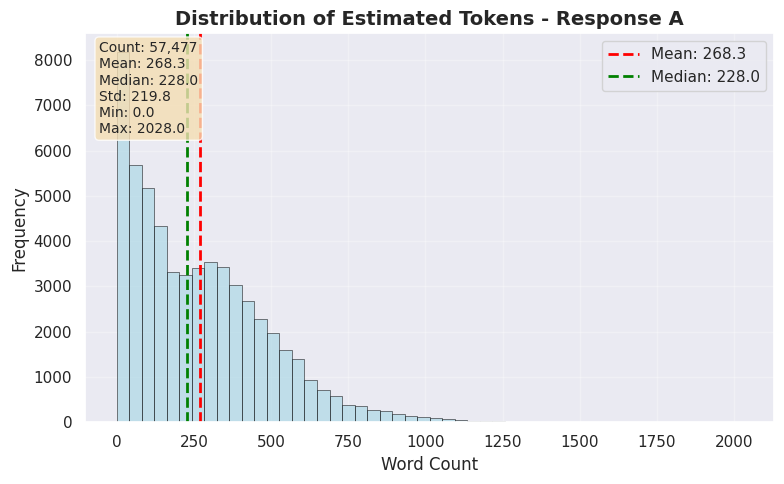


Distribution of Estimated Tokens - Response A - Summary Statistics:
Count: 57,477
Mean: 268.34
Median: 228.00
Standard Deviation: 219.77
Minimum: 0
Maximum: 2028
25th Percentile: 85.00
75th Percentile: 402.00


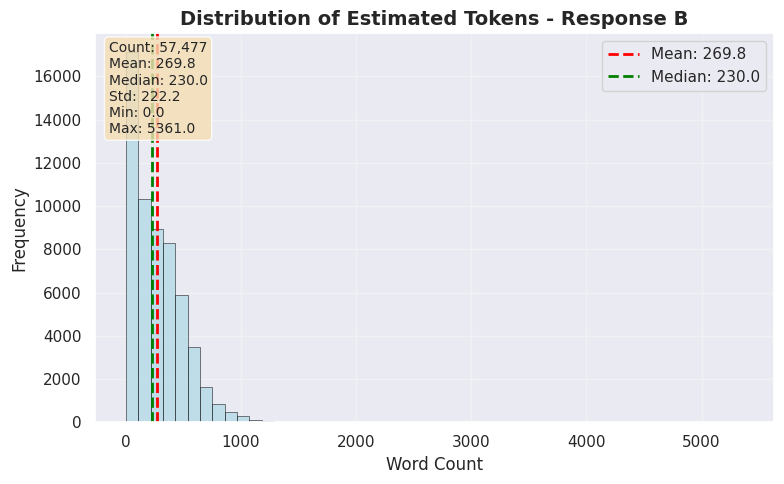


Distribution of Estimated Tokens - Response B - Summary Statistics:
Count: 57,477
Mean: 269.80
Median: 230.00
Standard Deviation: 222.18
Minimum: 0
Maximum: 5361
25th Percentile: 86.00
75th Percentile: 405.00


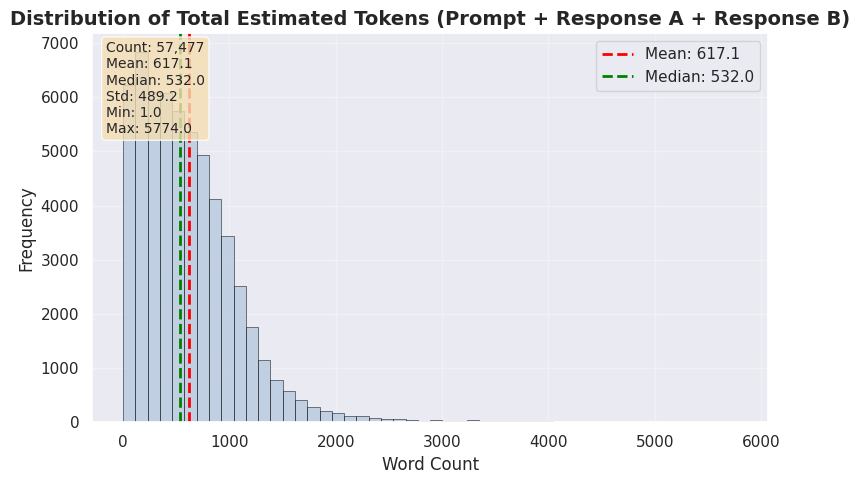


Distribution of Total Estimated Tokens (Prompt + Response A + Response B) - Summary Statistics:
Count: 57,477
Mean: 617.07
Median: 532.00
Standard Deviation: 489.16
Minimum: 1
Maximum: 5774
25th Percentile: 256.00
75th Percentile: 860.00


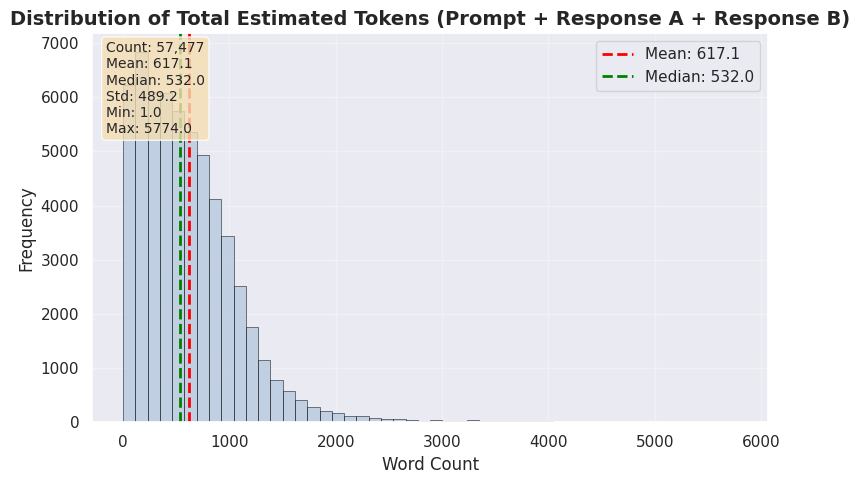

In [29]:
# Display distribution of estimated tokens of prompts
plot_word_count_distribution(
    df=train_ps_df,
    column_name='prompt_clean_estimated_tokens',
    title='Distribution of Estimated Tokens - Prompts',
    fig_width=800,
    fig_height=500,
    color='lightblue'
)

# Display distribution of estimated tokens of response_a
plot_word_count_distribution(
    df=train_ps_df,
    column_name='response_a_clean_estimated_tokens',
    title='Distribution of Estimated Tokens - Response A',
    fig_width=800,
    fig_height=500,
    color='lightblue'
)

# Display distribution of estimated tokens of response_b
plot_word_count_distribution(
    df=train_ps_df,
    column_name='response_b_clean_estimated_tokens',
    title='Distribution of Estimated Tokens - Response B',
    fig_width=800,
    fig_height=500,
    color='lightblue'
)

# Display distribution of total estimated tokens
plot_word_count_distribution(
    df=train_ps_df,
    column_name='total_estimated_tokens',
    title='Distribution of Total Estimated Tokens (Prompt + Response A + Response B)',
    fig_width=800,
    fig_height=500,
    color='lightsteelblue'
)

## EDA Results

ADD HERE

# 4.&nbsp;Train-Validation-Test Split

Split the dataset into training, validation, and test sets. Use tratified splitting to ensure that the class distribution remains consistent across these sets. The distribution of records across the labels is visualized to ensure a balanced split.

## Truncate Input Text to Fit Context Window

In [30]:
## TO DO: Custom Truncation of Input Data

## Make Pairs

In [31]:
def make_pairs(row):
    # Make options
    row['options'] = [
        f'Prompt: {row['prompt_clean']}\n\nResponse: {row['response_a_clean']}', # Response from Model A
        f'Prompt: {row['prompt_clean']}\n\nResponse: {row['response_b_clean']}', # Response from Model B
    ]
    return row

In [32]:
train_psp1_df = train_ps_df.apply(make_pairs, axis=1)
test_psp1_df = test_ps_df.apply(make_pairs, axis=1)

train_psp1_df['options'].iloc(0)

## Test Split

In [33]:
# Split the processed training data into training and validation sets
split_train_psp1_df, split_valid_psp1_df = train_test_split(
    train_psp1_df,                    # Source dataframe to split
    test_size=0.2,                    # 20% of data goes to validation set
    stratify=train_psp1_df['class_label']  # Maintain class distribution in both sets
)

## Test Split Analysis

In [34]:
# Shows the count of samples for each class label in the training data
split_train_psp1_df['class_label'].value_counts()

,count
class_label,
0,16051
1,15721
2,14209


In [35]:
# Shows the count of samples for each class label in the training data
split_valid_psp1_df['class_label'].value_counts()

,count
class_label,
0,4013
1,3931
2,3552


# 5.&nbsp;Preprocessing + Tokenization

{{xxxxx}}

## Core Normalization Functions - Default

In [36]:
# Initialize the text preprocessor from configuration
# This creates a tokenizer that will convert text to numerical tokens
preprocessor = CFG.preprocessor.from_preset(
    preset=CFG.preset,                    # Name of the model
    sequence_length=CFG.sequence_length   # Max sequence length, will be padded if shorter
)

preprocessor

# Function to preprocess individual text samples
# Converts text to tokens and handles optional labels
def preprocess_fn(text, label=None):
    tokens = preprocessor(text)  # Tokenize the input text
    return (tokens, label) if label is not None else (tokens, 0)

# Function to build a TensorFlow dataset from text data
# Handles preprocessing, batching, shuffling, and optimization
def build_dataset(texts, labels=None, batch_size=32, cache=False, shuffle=1024):  # DISABLED cache for memory
    AUTO = tf.data.AUTOTUNE  # Automatic optimization for parallel processing

    # Create dataset slices - handle both labeled and unlabeled data
    slices = (texts, ) if labels is None \
        else (texts, keras.utils.to_categorical(labels, num_classes=3))
    ds = tf.data.Dataset.from_tensor_slices(slices)

    # Cache dataset in memory for faster access during training
    ds = ds.cache() if cache else ds

    # Apply preprocessing function to each sample in parallel
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)

    # Configure dataset options for shuffling
    opt = tf.data.Options()
    if shuffle:
        ds = ds.shuffle(shuffle, seed=CFG.seed)  # Randomize order for better training
        opt.experimental_deterministic = False   # Allow non-deterministic operations for performance
    ds = ds.with_options(opt)

    # Create batches of specified size for training
    ds = ds.batch(batch_size, drop_remainder=False)

    # Prefetch data to GPU/CPU for faster training
    ds = ds.prefetch(AUTO)
    return ds

100%|██████████| 486/486 [00:00<00:00, 920kB/s]


100%|██████████| 614/614 [00:00<00:00, 1.25MB/s]


100%|██████████| 2.35M/2.35M [00:00<00:00, 3.37MB/s]


## Core Normalization Functions - Large Context


In [37]:
# Initialize the text preprocessor from configuration
# This creates a tokenizer that will convert text to numerical tokens
preprocessor_1000 = CFG.preprocessor_2.from_preset(
    preset=CFG.preset_2,                    # Name of the model
    sequence_length=CFG.sequence_length_2   # Max sequence length, will be padded if shorter
)

preprocessor_1000

# Function to preprocess individual text samples
# Converts text to tokens and handles optional labels
def preprocess_fn_1000(text, label=None):
    tokens = preprocessor_1000(text)  # Tokenize the input text
    return (tokens, label) if label is not None else (tokens, 0)

# Function to build a TensorFlow dataset from text data
# Handles preprocessing, batching, shuffling, and optimization
def build_dataset_1000(texts, labels=None, batch_size=32, cache=False, shuffle=1024):  # DISABLED cache for memory
    AUTO = tf.data.AUTOTUNE  # Automatic optimization for parallel processing

    # Create dataset slices - handle both labeled and unlabeled data
    slices = (texts, ) if labels is None \
        else (texts, keras.utils.to_categorical(labels, num_classes=3))
    ds = tf.data.Dataset.from_tensor_slices(slices)

    # Cache dataset in memory for faster access during training
    ds = ds.cache() if cache else ds

    # Apply preprocessing function to each sample in parallel
    ds = ds.map(preprocess_fn_1000, num_parallel_calls=AUTO)

    # Configure dataset options for shuffling
    opt = tf.data.Options()
    if shuffle:
        ds = ds.shuffle(shuffle, seed=CFG.seed)  # Randomize order for better training
        opt.experimental_deterministic = False   # Allow non-deterministic operations for performance
    ds = ds.with_options(opt)

    # Create batches of specified size for training
    ds = ds.batch(batch_size, drop_remainder=False)

    # Prefetch data to GPU/CPU for faster training
    ds = ds.prefetch(AUTO)
    return ds

100%|██████████| 486/486 [00:00<00:00, 889kB/s]


100%|██████████| 614/614 [00:00<00:00, 1.68MB/s]


100%|██████████| 2.35M/2.35M [00:00<00:00, 3.41MB/s]


## Build Training Data Loader

In [38]:
# Extract text data from the training dataframe
# Convert the 'options' column (containing processed text pairs) to a list
train_texts = split_train_psp1_df.options.tolist()

# Extract corresponding labels from the training dataframe
# Convert the 'class_label' column (containing target classifications) to a list
train_labels = split_train_psp1_df.class_label.tolist()

# Build the training dataset using the custom build_dataset function
# This creates an optimized TensorFlow dataset pipeline for training

# Model 0 (Baseline) - Uses CFG.batch_size (8)
train_ds = build_dataset(
    train_texts,
    train_labels,
    batch_size=CFG.batch_size,  # 8
    cache=True,
    shuffle=True
)

train_ds_1000 = build_dataset_1000(
    train_texts,
    train_labels,
    batch_size=CFG.batch_size_2,  # 4
    cache=True,
    shuffle=True
)

In [39]:

# Display the dataset object (shows dataset structure and configuration)
train_ds

<_PrefetchDataset element_spec=({'token_ids': TensorSpec(shape=(None, None, 512), dtype=tf.int32, name=None), 'padding_mask': TensorSpec(shape=(None, None, 512), dtype=tf.bool, name=None)}, TensorSpec(shape=(None, 3), dtype=tf.float64, name=None))>

In [40]:
# Display the dataset object (shows dataset structure and configuration)
train_ds_1000

<_PrefetchDataset element_spec=({'token_ids': TensorSpec(shape=(None, None, 1024), dtype=tf.int32, name=None), 'padding_mask': TensorSpec(shape=(None, None, 1024), dtype=tf.bool, name=None)}, TensorSpec(shape=(None, 3), dtype=tf.float64, name=None))>

## Build Validation Data Loader

In [41]:
# Extract text data from the validation dataframe
# Convert the 'options' column (containing processed text pairs) to a list
valid_texts = split_valid_psp1_df.options.tolist()

# Extract corresponding labels from the validation dataframe
# Convert the 'class_label' column (containing target classifications) to a list
valid_labels = split_valid_psp1_df.class_label.tolist()

# Build the validation dataset using the custom build_dataset function
# This creates an optimized TensorFlow dataset pipeline for validation

# Model 0 (Baseline) - Uses CFG.batch_size (8)
valid_ds = build_dataset(
    valid_texts,
    valid_labels,
    batch_size=CFG.batch_size,  # 8
    cache=True,
    shuffle=False
)

valid_ds_1000 = build_dataset_1000(
    valid_texts,
    valid_labels,
    batch_size=CFG.batch_size_2,  # 8
    cache=True,
    shuffle=False
)

In [42]:
# Display the dataset object (shows dataset structure and configuration)
valid_ds

<_PrefetchDataset element_spec=({'token_ids': TensorSpec(shape=(None, None, 512), dtype=tf.int32, name=None), 'padding_mask': TensorSpec(shape=(None, None, 512), dtype=tf.bool, name=None)}, TensorSpec(shape=(None, 3), dtype=tf.float64, name=None))>

In [43]:
# Display the dataset object (shows dataset structure and configuration)
valid_ds_1000

<_PrefetchDataset element_spec=({'token_ids': TensorSpec(shape=(None, None, 1024), dtype=tf.int32, name=None), 'padding_mask': TensorSpec(shape=(None, None, 1024), dtype=tf.bool, name=None)}, TensorSpec(shape=(None, 3), dtype=tf.float64, name=None))>

# 6.&nbsp;Define the Model Inputs


## Model Results Functions

In [57]:
def plot_training_metric(history, metric='loss', title=None):

    # Set default title if not provided
    if title is None:
        title = metric.replace('_', ' ').title()

    # Plot training and validation metrics
    plt.plot(history.history[metric], label=f'training_{metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'validation_{metric}')

    # Customize plot
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [58]:
def plot_confusion_matrix(y_true, y_pred, class_names=None, figsize=(8, 6), title="Confusion Matrix"):

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Set default class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(len(cm))]

    # Create the plot
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Print some statistics
    print(f"\nConfusion Matrix Statistics:")
    print(f"Total samples: {cm.sum()}")
    print(f"Correct predictions: {cm.trace()}")
    print(f"Accuracy: {cm.trace() / cm.sum():.4f}")

    return cm


In [59]:
def show_metrics(pred_tag, y_test):
    print("F1-score: ", f1_score(pred_tag, y_test, average='macro'))
    print("Precision: ", precision_score(pred_tag, y_test, average='macro'))
    print("Recall: ", recall_score(pred_tag, y_test, average='macro'))
    print("Accuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))

In [60]:
def evaluate_model(model, valid_ds, history, model_name="Model", show_plots=True):
    print(f"\n{'='*60}")
    print(f"EVALUATING {model_name.upper()}")
    print(f"{'='*60}")

    # Generate predictions
    pred_val = model.predict(valid_ds, verbose=1)
    print("number of predictions:", len(pred_val))
    # Get predicted class labels (argmax of probabilities)
    label_pred_val = np.argmax(pred_val, axis=1)

    # Show detailed metrics
    show_metrics(label_pred_val, valid_labels)

    # Plot confusion matrix
    print(f"\n{model_name} Confusion Matrix:")
    cm = plot_confusion_matrix(
        y_true=valid_labels,
        y_pred=label_pred_val,
        class_names=CFG.class_names,
        title=f"{model_name} - Confusion Matrix"
    )

    # Plot training curves if requested
    if show_plots:
        print(f"\n{model_name} Training Curves:")
        # Plot loss curves
        plot_training_metric(history, 'loss')
        # Plot log loss curves
        plot_training_metric(history, 'log_loss')
        # Plot accuracy curves
        plot_training_metric(history, 'accuracy')

    # Return evaluation results
    return {
        'model_name': model_name,
        'f1_score': f1_score(label_pred_val, valid_labels, average='macro'),
        'precision': precision_score(label_pred_val, valid_labels, average='macro'),
        'recall': recall_score(label_pred_val, valid_labels, average='macro'),
        'accuracy': accuracy_score(label_pred_val, valid_labels),
        'confusion_matrix': cm
    }

## Learning Rate Schedule

> Add blockquote



In [61]:
# Custom learning rate scheduler function with cosine annealing
# Creates a learning rate schedule that ramps up, sustains, then decays
def get_lr_callback(batch_size=8, epochs=10, plot=False):
    # Define learning rate parameters
    lr_start, lr_max, lr_min = 1e-6, 0.3e-6 * batch_size, 1e-6  # Start, max, and minimum learning rates
    lr_ramp_ep, lr_sus_ep, lr_decay = 2, 0, 0.8  # Ramp epochs, sustain epochs, decay factor

    # Inner function that calculates learning rate for each epoch
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            # Linear ramp-up phase: gradually increase from start to max
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:
            # Sustained phase: maintain maximum learning rate
            lr = lr_max
        else:
            # Cosine decay phase: smooth decrease from max to min using cosine annealing
            decay_total_epochs = epochs - (lr_ramp_ep + lr_sus_ep) - 1
            decay_epoch_index = epoch - (lr_ramp_ep + lr_sus_ep)
            phase = math.pi * decay_epoch_index / decay_total_epochs
            # print(decay_total_epochs, decay_epoch_index, phase)  # Debug output
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    # Optional visualization of the learning rate schedule
    if plot:
        plt.figure()
        x_values = np.arange(1, epochs + 1)  # Create array of epoch numbers
        lr_values = [lrfn(epoch) for epoch in range(epochs)]  # Calculate LR for each epoch
        plt.plot(x_values, lr_values, marker='o')  # Plot LR curve
        plt.xlabel('epoch')
        plt.ylabel('lr')
        plt.ylim(0, 0.6e-5)  # Set y-axis limits for better visualization
        plt.title('LR Scheduler')
        plt.show()

    # Return a Keras callback that applies the learning rate schedule during training
    return keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

## Build Model Measuement Metric

In [62]:
# Define the loss function for multi-class classification
# CategoricalCrossentropy is used when targets are one-hot encoded (3 classes: model A wins, model B wins, tie)
log_loss = keras.metrics.CategoricalCrossentropy(name="log_loss")

## Model Checkpointing

In [63]:
# Function to create ModelCheckpoint callbacks with customizable parameters
# This allows for easy experimentation with different checkpointing strategies
def create_model_checkpoint_callback(
    filepath='best_model.weights.h5',  # File path where to save the best model weights
    monitor='val_log_loss',            # Metric to monitor (default: validation loss)
    save_best_only=True,               # Only save when the monitored metric improves
    save_weights_only=True,            # Save only the model weights (not the full model)
    mode='min',                        # Save when metric improves (min/max)
    save_freq='epoch',                 # Save frequency ('epoch' or integer)
    verbose=1,                         # Verbosity level (0=silent, 1=print messages)
    name_suffix=""                     # Optional suffix for file identification
):
    # Add suffix to filename if provided
    if name_suffix:
        base_name, ext = os.path.splitext(filepath)
        filepath = f"{base_name}{name_suffix}{ext}"

    return keras.callbacks.ModelCheckpoint(
        filepath=filepath,
        monitor=monitor,
        save_best_only=save_best_only,
        save_weights_only=save_weights_only,
        mode=mode,
        save_freq=save_freq,
        verbose=verbose
    )

## Early Stopping

In [64]:
# Function to create EarlyStopping callbacks with customizable parameters
# This allows for easy experimentation with different early stopping strategies
def create_early_stopping_callback(
    monitor='val_log_loss',      # Metric to monitor (default: validation loss)
    min_delta=0.0001,           # Minimum change to qualify as an improvement
    patience=3,                 # Number of epochs to wait before stopping
    verbose=1,                  # Print messages when stopping is triggered
    mode='min',                 # Stop when metric stops improving (min/max)
    baseline=None,              # Baseline threshold for stopping
    restore_best_weights=True,  # Restore best weights when stopping
    start_from_epoch=0,         # Start monitoring from this epoch
    name_suffix=""              # Optional suffix for callback identification
):

    return keras.callbacks.EarlyStopping(
        monitor=monitor,
        min_delta=min_delta,
        patience=patience,
        verbose=verbose,
        mode=mode,
        baseline=baseline,
        restore_best_weights=restore_best_weights,
        start_from_epoch=start_from_epoch
    )

# Epoch Time Logging

In [65]:
# Define a time element to add to history of model training
class EpochTimeHistory(Callback):
    """A custom Keras callback to record the duration of each epoch."""
    def on_epoch_begin(self, epoch, logs=None):
        # Record the start time at the beginning of each epoch
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        # Calculate the epoch's duration
        epoch_duration = time.time() - self.epoch_start_time

        # Add the duration to the logs dictionary.
        # Keras will automatically include this in the final history object.
        if logs is not None:
            logs['epoch_duration'] = epoch_duration

# 7.&nbsp; Baseline Models: LLM Finetuning

## Model Architecture

In [66]:
def create_model_baseline():
    # Define input layers for the model
    # The model expects two inputs: tokenized text and padding masks
    # Shape (2, None) represents 2 sequences (prompt+response_a, prompt+response_b) of variable length
    inputs = {
        "token_ids": keras.Input(shape=(2, None), dtype=tf.int32, name="token_ids"),      # Tokenized text input
        "padding_mask": keras.Input(shape=(2, None), dtype=tf.int32, name="padding_mask"), # Mask for padding tokens
    }

    # Create a DeBERTa v3 backbone model for text encoding
    # This is the pre-trained transformer that will encode the text into embeddings
    # Use the preset model configuration (deberta_v3_extra_small_en)
    backbone = CFG.backbone.from_preset(CFG.preset)

    # Process the first response pair: (Prompt + Response_A)
    # Extract the first sequence from the input tensors (index 0)
    response_a = {k: v[:, 0, :] for k, v in inputs.items()}
    embed_a = backbone(response_a)  # Get embeddings for prompt + response A

    # Process the second response pair: (Prompt + Response_B)
    # Extract the second sequence from the input tensors (index 1)
    response_b = {k: v[:, 1, :] for k, v in inputs.items()}
    embed_b = backbone(response_b)  # Get embeddings for prompt + response B

    # Combine the embeddings from both responses
    # Concatenate embeddings along the last dimension to create a combined representation
    embeds = keras.layers.Concatenate(axis=-1)([embed_a, embed_b])

    # Apply global average pooling to reduce sequence dimension
    # This creates a fixed-size representation regardless of input length
    embeds = keras.layers.GlobalAveragePooling1D()(embeds)

    # Final classification layer
    # Dense layer with 3 outputs (model A wins, model B wins, tie) and softmax activation
    outputs = keras.layers.Dense(3, activation="softmax", name="classifier")(embeds)

    # Create the complete model by connecting inputs to outputs
    model = keras.Model(inputs, outputs, name="Model_0_Baseline")

    return model

## Compile the Model

In [67]:
# Instantiate the Model
model_0 = create_model_baseline()
# Define the log loss function for the model
log_loss_0 = keras.metrics.CategoricalCrossentropy(name="log_loss")
# Create a fresh optimizer instance for this model to avoid variable conflicts
optimizer_0 = keras.optimizers.Adam(5e-6)
# Compile the model with optimizer, loss function, and evaluation metrics
model_0.compile(
    optimizer=optimizer_0,  # Fresh Adam optimizer with very low learning rate
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02),  # Loss with label smoothing
    metrics=[
        log_loss_0,  # Custom log loss metric for competition evaluation
        keras.metrics.CategoricalAccuracy(name="accuracy"),  # Standard accuracy metric
    ],
    jit_compile=True # Disable XLA to fix eager execution issues
)
# Display the model architecture
model_0.summary()

Model: "Model_0_Baseline"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, 2, None)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, 2, None)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, None)      │          0 │ padding_mask[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, None)      │          0 │ token_ids[0][0]   │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, None)      │          0 │ padding_mask[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, None)      │          0 │ token_ids[0][0]   │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deberta_v3_backbone │ (None, None, 384) │ 70,682,112 │ get_item_5[0][0], │
│ (DebertaV3Backbone) │                   │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_7[0][0], │
│                     │                   │            │ get_item_6[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, None, 768) │          0 │ deberta_v3_backb… │
│ (Concatenate)       │                   │            │ deberta_v3_backb… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 768)       │          0 │ concatenate_1[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier (Dense)  │ (None, 3)         │      2,307 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 70,684,419 (269.64 MB)

 Trainable params: 70,684,419 (269.64 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

Training Baseline Model (Model 0)...
Memory usage before training: 3439.5 MB


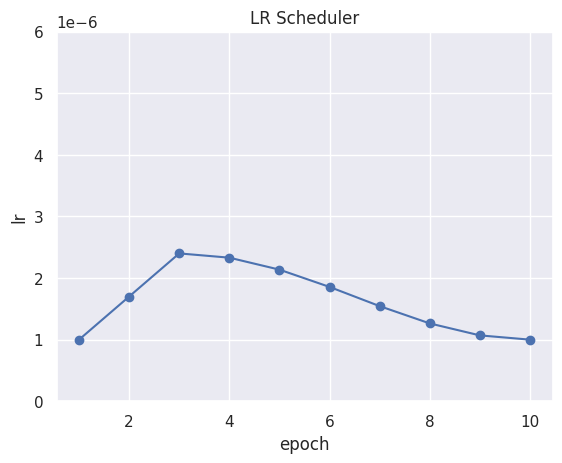


Epoch 1: LearningRateScheduler setting learning rate to 1e-06.
Epoch 1/10
5748/5748 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.4181 - log_loss: 1.0868 - loss: 1.0882
Epoch 1: val_log_loss improved from inf to 1.06539, saving model to model_0.best_weights.weights.h5
5748/5748 ━━━━━━━━━━━━━━━━━━━━ 832s 110ms/step - accuracy: 0.4181 - log_loss: 1.0868 - loss: 1.0881 - val_accuracy: 0.4360 - val_log_loss: 1.0654 - val_loss: 1.0673 - learning_rate: 1.0000e-06 - epoch_duration: 832.4660

Epoch 2: LearningRateScheduler setting learning rate to 1.6999999999999998e-06.
Epoch 2/10
5748/5748 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4503 - log_loss: 1.0548 - loss: 1.0568
Epoch 2: val_log_loss improved from 1.06539 to 1.05173, saving model to model_0.best_weights.weights.h5
5748/5748 ━━━━━━━━━━━━━━━━━━━━ 470s 82ms/step - accuracy: 0.4503 - log_loss: 1.0548 - loss: 1.0568 - val_accuracy: 0.4499 - val_log_loss: 1.0517 - val_loss: 1.0540 - learning_rate: 1.7000e-06 - epoch_duration: 470.2

In [68]:
# Check if baseline model training is enabled
if CFG.train_baseline:
    print("Training Baseline Model (Model 0)...")
    print_memory_usage("before training")

    # Create the learning rate callback with current configuration
    # Uses batch size and epochs from CFG, and displays the LR schedule plot
    lr_cb_0 = get_lr_callback(CFG.batch_size, CFG.epochs, plot=True)
    # Create the default model checkpoint callback for current experiment
    ckpt_cb_0 = create_model_checkpoint_callback(
        filepath='model_0.best_weights.weights.h5'
    )
    # Create the default early stopping callback for current experiment
    early_stopping_cb_0 = create_early_stopping_callback()
    # Add time logging to the results
    time_history_cb_0 = EpochTimeHistory()

    # Start training the model
    history_0 = model_0.fit(
        train_ds,
        epochs=CFG.epochs,
        validation_data=valid_ds,
        verbose = 1,
        callbacks=[
            lr_cb_0,
            ckpt_cb_0,
            early_stopping_cb_0,
            time_history_cb_0
        ]
    )
else:
    print("Baseline Model training is DISABLED. Skipping training...")
    history_0 = None

print_memory_usage("after training")

## Evaluate the Model


EVALUATING BASELINE MODEL
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step
number of predictions: 11496
F1-score:  0.45069915363462726
Precision:  0.46156688321220857
Recall:  0.47178513983284104
Accuracy:  0.46903270702853167
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.53      0.49      0.51      4356
           1       0.61      0.45      0.52      5283
           2       0.25      0.48      0.33      1857

    accuracy                           0.47     11496
   macro avg       0.46      0.47      0.45     11496
weighted avg       0.52      0.47      0.48     11496


Baseline Model Confusion Matrix:


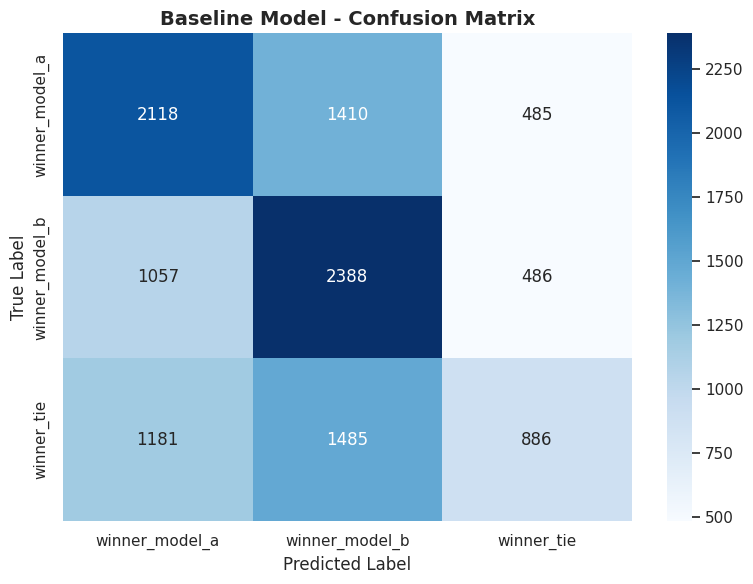


Confusion Matrix Statistics:
Total samples: 11496
Correct predictions: 5392
Accuracy: 0.4690

Baseline Model Training Curves:


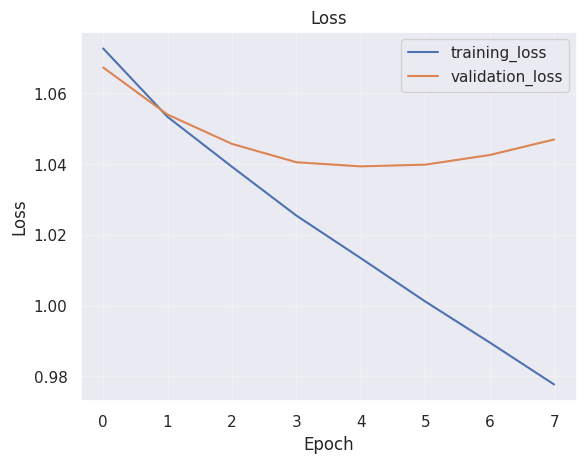

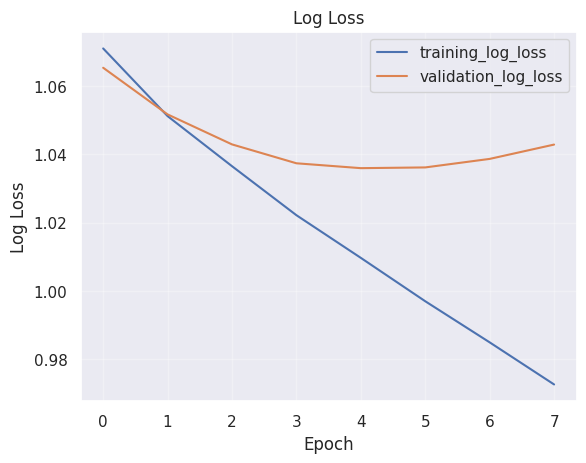

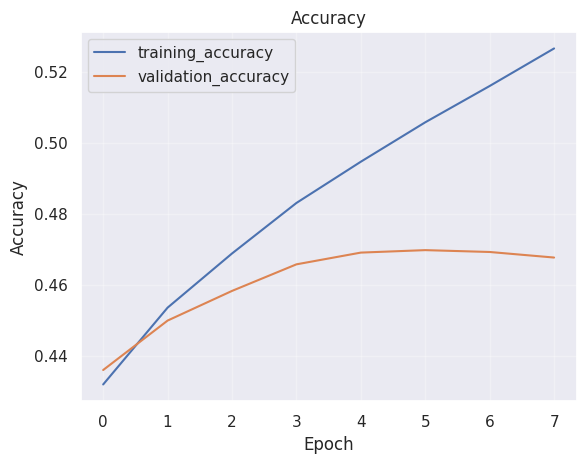

In [69]:
# Process Results of Model (only if training was enabled):
if CFG.train_baseline and history_0 is not None:
    results_0 = evaluate_model(
        model=model_0,
        valid_ds=valid_ds,
        history=history_0,
        model_name="Baseline Model",
        show_plots=True
    )
else:
    print("Baseline Model evaluation skipped - training was disabled.")
    results_0 = None

## Save the Model

In [70]:
def save_model_and_history(model, history, model_name, save_dir=None):

    # Set default save directory for Colab environment
    if save_dir is None:
        if gIS_COLAB:
            save_dir = '/content/drive/MyDrive/[1.4] MsDS Class Files/-- DTSA 5511 Deep Learning/saved_models'
        else:
            save_dir = './saved_models'

    # Create save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Define file paths
    model_path = os.path.join(save_dir, f'{model_name}.keras')
    history_path = os.path.join(save_dir, f'{model_name}_history.pkl')

    # Save the model
    model.save(model_path)

    # Save training history as pickle file (preserves exact data types)
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)

    # Print confirmation
    print(f"Training history saved to:")
    print(f"  - Model file: {model_path}")
    print(f"  - History file: {history_path}")

    return {
        'model_path': model_path,
        'history_path': history_path,
        'model_name': model_name
    }

In [71]:
model_0_paths = save_model_and_history(model_0, history_0, 'llm_0_baseline_model')

Training history saved to:
  - Model file: /content/drive/MyDrive/[1.4] MsDS Class Files/-- DTSA 5511 Deep Learning/saved_models/llm_0_baseline_model.keras
  - History file: /content/drive/MyDrive/[1.4] MsDS Class Files/-- DTSA 5511 Deep Learning/saved_models/llm_0_baseline_model_history.pkl


In [72]:
def load_model_and_history(model_name, save_dir=None):

    # Set default save directory for Colab environment
    if save_dir is None:
        if gIS_COLAB:
            save_dir = '/content/drive/MyDrive/[1.4] MsDS Class Files/-- DTSA 5511 Deep Learning/saved_models'
        else:
            save_dir = './saved_models'

    # Define file paths
    model_path = os.path.join(save_dir, f'{model_name}.keras')
    history_path = os.path.join(save_dir, f'{model_name}_history.pkl')

    # Check if files exist
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")
    if not os.path.exists(history_path):
        raise FileNotFoundError(f"History file not found: {history_path}")

    # Load the model
    # Note: If you have custom objects, uncomment and modify the custom_objects line
    # custom_objects = {'YourCustomClass': YourCustomClass}
    # loaded_model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
    loaded_model = tf.keras.models.load_model(model_path)

    # Load the training history
    with open(history_path, 'rb') as f:
        loaded_history_dict = pickle.load(f)

    # Create a History object for compatibility
    loaded_history = History()
    loaded_history.history = loaded_history_dict

    # Set epoch information if available
    if 'loss' in loaded_history_dict:
        loaded_history.epoch = list(range(len(loaded_history_dict['loss'])))
    else:
        # Fallback: use the length of the first available metric
        first_key = list(loaded_history_dict.keys())[0]
        loaded_history.epoch = list(range(len(loaded_history_dict[first_key])))

    print("Model and history loaded successfully!")
    print(f"Model path: {model_path}")
    print(f"History path: {history_path}")
    print(f"Model name: {model_name}")

    return {
        'model': loaded_model,
        'history': loaded_history,
        'model_path': model_path,
        'history_path': history_path,
        'model_name': model_name
    }


In [73]:
# Load baseline model
baseline_0 = load_model_and_history('llm_0_baseline_model')
model_0_loaded = baseline_0['model']
history_0_loaded = baseline_0['history']

Model and history loaded successfully!
Model path: /content/drive/MyDrive/[1.4] MsDS Class Files/-- DTSA 5511 Deep Learning/saved_models/llm_0_baseline_model.keras
History path: /content/drive/MyDrive/[1.4] MsDS Class Files/-- DTSA 5511 Deep Learning/saved_models/llm_0_baseline_model_history.pkl
Model name: llm_0_baseline_model


In [74]:

def review_training_history(history, model_name="Model", show_epoch_times=True):

    # Handle both History objects and dictionaries
    if hasattr(history, 'history'):
        history_dict = history.history
    else:
        history_dict = history

    # Create DataFrame from history
    history_df = pd.DataFrame(history_dict)
    history_df.index += 1  # Start epoch numbering from 1

    # Round epoch duration to 2 decimal places if it exists
    if 'epoch_duration' in history_df.columns:
        history_df['epoch_duration'] = history_df['epoch_duration'].round(2)

    # Display the results
    print(f"\n--- {model_name} Training History ---")
    if show_epoch_times and 'epoch_duration' in history_df.columns:
        print("(Includes epoch duration information)")

    print(history_df)

    # Optional: Show summary statistics
    print(f"\n--- {model_name} Summary Statistics ---")
    print(f"Total epochs: {len(history_df)}")

    return history_df

# Example usage:
# history_df = review_training_history(loaded_history_best, "Best Model")
# history_df = review_training_history(history_0, "Baseline Model")
# history_df = review_training_history(history_1, "Experiment 1 Model")

In [75]:
# Review baseline model history
baseline_history_df = review_training_history(history_0, "llm_0_baseline_model")


--- llm_0_baseline_model Training History ---
(Includes epoch duration information)
   accuracy  log_loss      loss  val_accuracy  val_log_loss  val_loss  \
1  0.431918  1.071043  1.072699      0.435978      1.065392  1.067318   
2  0.453535  1.051226  1.053346      0.449896      1.051730  1.053998   
3  0.468781  1.036563  1.039240      0.458246      1.042946  1.045708   
4  0.483004  1.022212  1.025431      0.465727      1.037414  1.040519   
5  0.494617  1.009716  1.013382      0.469033      1.035988  1.039356   
6  0.505709  0.997012  1.001143      0.469729      1.036202  1.039843   
7  0.515930  0.984977  0.989561      0.469207      1.038698  1.042563   
8  0.526500  0.972648  0.977686      0.467641      1.042892  1.046952   

   learning_rate  epoch_duration  
1   1.000000e-06          832.47  
2   1.700000e-06          470.28  
3   2.400000e-06          467.91  
4   2.330678e-06          468.30  
5   2.136443e-06          467.20  
6   1.855765e-06          463.50  
7   1.544235


EVALUATING BASELINE MODEL
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 44s 17ms/step
number of predictions: 11496
F1-score:  0.45069915363462726
Precision:  0.46156688321220857
Recall:  0.47178513983284104
Accuracy:  0.46903270702853167
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.53      0.49      0.51      4356
           1       0.61      0.45      0.52      5283
           2       0.25      0.48      0.33      1857

    accuracy                           0.47     11496
   macro avg       0.46      0.47      0.45     11496
weighted avg       0.52      0.47      0.48     11496


Baseline Model Confusion Matrix:


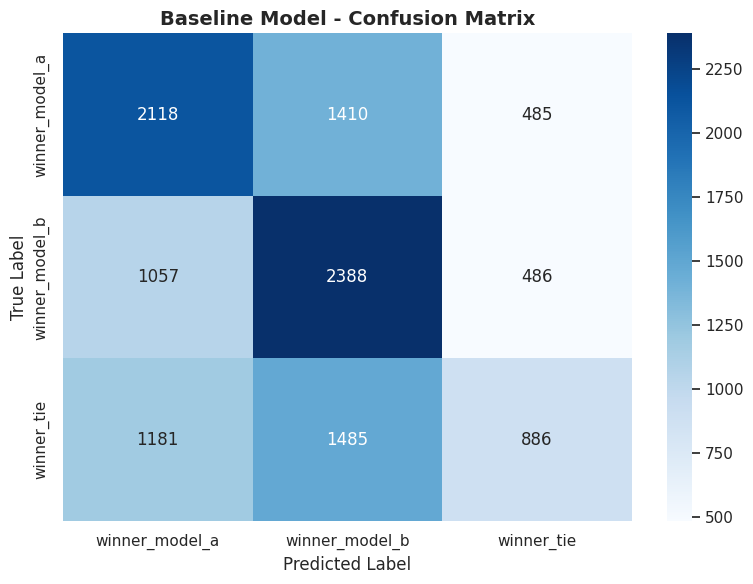


Confusion Matrix Statistics:
Total samples: 11496
Correct predictions: 5392
Accuracy: 0.4690

Baseline Model Training Curves:


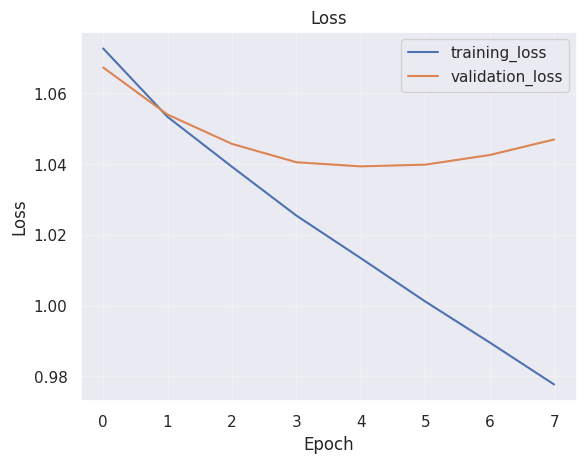

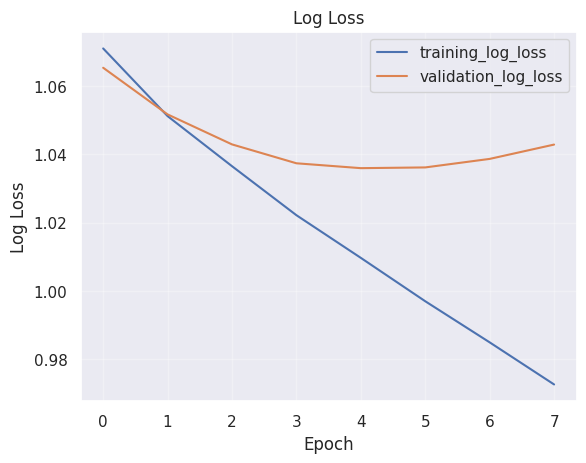

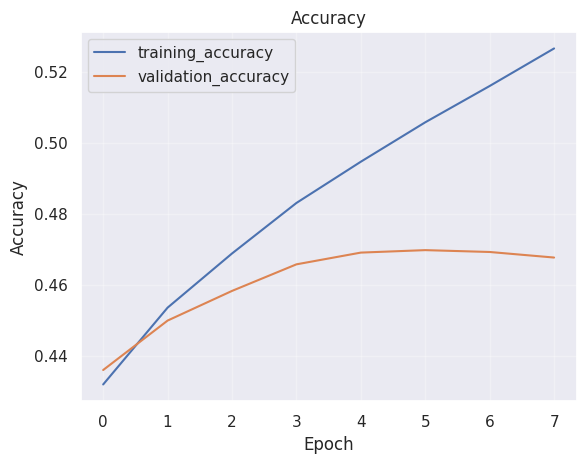

In [76]:
# Process Results of Model (only if training was enabled):
if CFG.train_baseline and history_0_loaded is not None:
    results_0_loaded = evaluate_model(
        model=model_0_loaded,
        valid_ds=valid_ds,
        history=history_0_loaded,
        model_name="Baseline Model",
        show_plots=True
    )
else:
    print("Baseline Model evaluation skipped - training was disabled.")
    results_0_loaded = None

# 8.1.&nbsp; Experiment 1: Train with AdamW Optimizer

## Model Architecture

In [77]:
# The same model architecture is used for this experiment

## Compile the Model

In [78]:
# Compile the model with optimizer, loss function, and evaluation metrics
model_1 = create_model_baseline()
# Define the log loss function for the model
log_loss_1 = keras.metrics.CategoricalCrossentropy(name="log_loss")
# Create a fresh optimizer instance for this model to avoid variable conflicts
optimizer_1 = keras.optimizers.AdamW(5e-6, weight_decay=0.01)
# Compile the model with optimizer, loss function, and evaluation metrics
model_1.compile(
    optimizer=optimizer_1,  # Fresh AdamW optimizer with very low learning rate
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02),  # Loss with label smoothing
    metrics=[
        log_loss_1,  # Custom log loss metric for competition evaluation
        keras.metrics.CategoricalAccuracy(name="accuracy"),  # Standard accuracy metric
    ],
    jit_compile=True # Disable XLA to fix eager execution issues
)
# Display the model architecture
model_1.summary()

Model: "Model_0_Baseline"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, 2, None)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, 2, None)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_9          │ (None, None)      │          0 │ padding_mask[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None, None)      │          0 │ token_ids[0][0]   │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_11         │ (None, None)      │          0 │ padding_mask[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_10         │ (None, None)      │          0 │ token_ids[0][0]   │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deberta_v3_backbone │ (None, None, 384) │ 70,682,112 │ get_item_9[0][0], │
│ (DebertaV3Backbone) │                   │            │ get_item_8[0][0], │
│                     │                   │            │ get_item_11[0][0… │
│                     │                   │            │ get_item_10[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, None, 768) │          0 │ deberta_v3_backb… │
│ (Concatenate)       │                   │            │ deberta_v3_backb… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 768)       │          0 │ concatenate_2[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier (Dense)  │ (None, 3)         │      2,307 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 70,684,419 (269.64 MB)

 Trainable params: 70,684,419 (269.64 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [79]:
# Check if Experiment 1 model training is enabled
if CFG.train_experiment_1:
    print("Training Experiment 1 Model (Model 1 - AdamW Optimizer)...")
    print_memory_usage("before training")

    # Create the learning rate callback with current configuration
    # Uses batch size and epochs from CFG, and displays the LR schedule plot
    lr_cb_1 = get_lr_callback(CFG.batch_size, CFG.epochs, plot=True)
    # Create the default model checkpoint callback for current experiment
    ckpt_cb_1 = create_model_checkpoint_callback(
        filepath='model_1.best_weights.weights.h5'
    )
    # Create the default early stopping callback for current experiment
    early_stopping_cb_1 = create_early_stopping_callback()
    # Add time logging to the results
    time_history_cb_1 = EpochTimeHistory()

    # Start training the model
    history_1 = model_1.fit(
        train_ds,
        epochs=CFG.epochs,
        validation_data=valid_ds,
        verbose = 1,
        callbacks=[
            lr_cb_1,
            ckpt_cb_1,
            early_stopping_cb_1,
            time_history_cb_1
        ]
    )
else:
    print("Experiment 1 Model training is DISABLED. Skipping training...")
    history_1 = None

print_memory_usage("after training")

Experiment 1 Model training is DISABLED. Skipping training...
Memory usage after training: 9710.5 MB


## Evaluate the Model

In [80]:
# Process Results of Model (only if training was enabled):
if CFG.train_experiment_1 and history_1 is not None:
    results_1 = evaluate_model(
        model=model_1,
        valid_ds=valid_ds,
        history=history_1,
        model_name="Experiment 1 Model (AdamW)",
        show_plots=True
    )
else:
    print("Experiment 1 Model evaluation skipped - training was disabled.")
    results_1 = None

Experiment 1 Model evaluation skipped - training was disabled.


## Save the Model

In [ ]:
model_1_paths = save_model_and_history(model_1, history_1, 'llm_1_adamw_model')

In [ ]:
# Load baseline model
baseline_1 = load_model_and_history('llm_1_adamw_model')
model_1_loaded = baseline_1['model']
history_1_loaded = baseline_1['history']

In [ ]:
# Review baseline model history
history_1_df = review_training_history(history_1, "llm_1_baseline_model")

In [ ]:
# Process Results of Model (only if training was enabled):
if CFG.train_experiment_1 and history_1_loaded is not None:
    results_1_loaded = evaluate_model(
        model=model_1_loaded,
        valid_ds=valid_ds,
        history=history_1_loaded,
        model_name="Experiment 1 Model (AdamW)",
        show_plots=True
    )
else:
    print("Baseline Model evaluation skipped - training was disabled.")
    results_1_loaded = None

# 8.2.&nbsp; Experiment 2: Larger Context Model

## Model Architecture

In [81]:
def create_model_1000():

    # Define input layers for the model
    # The model expects two inputs: tokenized text and padding masks
    # Shape (2, None) represents 2 sequences (prompt+response_a, prompt+response_b) of variable length
    inputs = {
        "token_ids": keras.Input(shape=(2, None), dtype=tf.int32, name="token_ids"),      # Tokenized text input
        "padding_mask": keras.Input(shape=(2, None), dtype=tf.int32, name="padding_mask"), # Mask for padding tokens
    }

    # Create a DeBERTa v3 backbone model for text encoding with larger context
    # Use the Experiment 2 preset model configuration (deberta_v3_small_en)
    backbone = CFG.backbone_2.from_preset(CFG.preset_2)

    # Process the first response pair: (Prompt + Response_A)
    # Extract the first sequence from the input tensors (index 0)
    response_a = {k: v[:, 0, :] for k, v in inputs.items()}
    embed_a = backbone(response_a)  # Get embeddings for prompt + response A

    # Process the second response pair: (Prompt + Response_B)
    # Extract the second sequence from the input tensors (index 1)
    response_b = {k: v[:, 1, :] for k, v in inputs.items()}
    embed_b = backbone(response_b)  # Get embeddings for prompt + response B

    # Combine the embeddings from both responses
    # Concatenate embeddings along the last dimension to create a combined representation
    embeds = keras.layers.Concatenate(axis=-1)([embed_a, embed_b])

    # Apply global average pooling to reduce sequence dimension
    # This creates a fixed-size representation regardless of input length
    embeds = keras.layers.GlobalAveragePooling1D()(embeds)

    # Final classification layer
    # Dense layer with 3 outputs (model A wins, model B wins, tie) and softmax activation
    outputs = keras.layers.Dense(3, activation="softmax", name="classifier")(embeds)

    # Create the complete model by connecting inputs to outputs
    model = keras.Model(inputs, outputs, name="Model_2_LargerContext")

    return model

## Compile the Model

In [82]:
# Compile the model with optimizer, loss function, and evaluation metrics
model_2 = create_model_1000()
# Define the log loss function for the model
log_loss_2 = keras.metrics.CategoricalCrossentropy(name="log_loss")
# Create a fresh optimizer instance for this model to avoid variable conflicts
optimizer_2 = keras.optimizers.Adam(5e-6)
# Compile the model with optimizer, loss function, and evaluation metrics
model_2.compile(
    optimizer=optimizer_2,  # Fresh Adam optimizer with very low learning rate
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02),  # Loss with label smoothing
    metrics=[
        log_loss_2,  # Custom log loss metric for competition evaluation
        keras.metrics.CategoricalAccuracy(name="accuracy"),  # Standard accuracy metric
    ],
    jit_compile=True # Disable XLA to fix eager execution issues
)
# Display the model architecture
model_2.summary()

Model: "Model_2_LargerContext"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, 2, None)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, 2, None)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_13         │ (None, None)      │          0 │ padding_mask[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_12         │ (None, None)      │          0 │ token_ids[0][0]   │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_15         │ (None, None)      │          0 │ padding_mask[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_14         │ (None, None)      │          0 │ token_ids[0][0]   │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deberta_v3_backbone │ (None, None, 768) │ 141,304,3… │ get_item_13[0][0… │
│ (DebertaV3Backbone) │                   │            │ get_item_12[0][0… │
│                     │                   │            │ get_item_15[0][0… │
│                     │                   │            │ get_item_14[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, None,      │          0 │ deberta_v3_backb… │
│ (Concatenate)       │ 1536)             │            │ deberta_v3_backb… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1536)      │          0 │ concatenate_3[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier (Dense)  │ (None, 3)         │      4,611 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 141,308,931 (539.05 MB)

 Trainable params: 141,308,931 (539.05 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [83]:
# Check if Experiment 2 model training is enabled
if CFG.train_experiment_2:
    print("Training Experiment 2 Model (Model 2 - Larger Context Architecture)...")
    print_memory_usage("before training")

    # Create the learning rate callback with current configuration
    # Uses batch size and epochs from CFG, and displays the LR schedule plot
    lr_cb_2 = get_lr_callback(CFG.batch_size_2, CFG.epochs, plot=True)
    # Create the default model checkpoint callback for current experiment
    ckpt_cb_2 = create_model_checkpoint_callback(
        filepath='model_2.best_weights.weights.h5'
    )
    # Create the default early stopping callback for current experiment
    early_stopping_cb_2 = create_early_stopping_callback()
    # Add time logging to the results
    time_history_cb_2 = EpochTimeHistory()

    # Start training the model
    history_2 = model_2.fit(
        train_ds_1000,
        epochs=CFG.epochs,
        validation_data=valid_ds_1000,
        verbose = 1,
        callbacks=[
            lr_cb_2,
            ckpt_cb_2,
            early_stopping_cb_2,
            time_history_cb_2
        ]
    )
else:
    print("Experiment 2 Model training is DISABLED. Skipping training...")
    history_2 = None

print_memory_usage("after training")

Experiment 2 Model training is DISABLED. Skipping training...
Memory usage after training: 10088.5 MB


## Evaluate the Model

In [84]:
# Process Results of Model (only if training was enabled):
if CFG.train_experiment_2 and history_2 is not None:
    results_2 = evaluate_model(
        model=model_2,
        valid_ds=valid_ds_1000,
        history=history_2,
        model_name="Experiment 2 Model (Model 2 - Larger Context)",
        show_plots=True
    )
else:
    print("Experiment 2 Model evaluation skipped - training was disabled.")
    results_2 = None

Experiment 2 Model evaluation skipped - training was disabled.


# 8.3.&nbsp; Experiment 3: Changed Architecture

## Model Architecture

In [85]:
def create_model_enhanced():
    # Define input layers for the model
    # The model expects two inputs: tokenized text and padding masks
    inputs = {
        "token_ids": keras.Input(shape=(2, None), dtype=tf.int32, name="token_ids"),      # Tokenized text input
        "padding_mask": keras.Input(shape=(2, None), dtype=tf.int32, name="padding_mask"), # Mask for padding tokens
    }

    # Create a DeBERTa v3 backbone model for text encoding
    # This is the pre-trained transformer that will encode the text into embeddings
    backbone = CFG.backbone_3.from_preset(CFG.preset_3)

    # Process the first response pair: (Prompt + Response_A)
    response_a = {k: v[:, 0, :] for k, v in inputs.items()}
    embed_a = backbone(response_a)  # Get embeddings for prompt + response A

    # Process the second response pair: (Prompt + Response_B)
    response_b = {k: v[:, 1, :] for k, v in inputs.items()}
    embed_b = backbone(response_b)  # Get embeddings for prompt + response B

    # Concatenate embeddings along the last dimension to create a combined representation
    embeds = keras.layers.Concatenate(axis=-1)([embed_a, embed_b])

    # Apply global average pooling to reduce sequence dimension
    embeds = keras.layers.GlobalAveragePooling1D()(embeds)

    # =============================================================================
    # ENHANCED MULTI-LAYER CLASSIFICATION HEAD (Experiment 4)
    # =============================================================================
    # First hidden layer with ReLU activation and dropout
    x = keras.layers.Dense(512, activation="relu", name="hidden_1")(embeds)
    x = keras.layers.Dropout(0.3, name="dropout_1")(x)

    # Second hidden layer with ReLU activation and dropout
    x = keras.layers.Dense(256, activation="relu", name="hidden_2")(x)
    x = keras.layers.Dropout(0.2, name="dropout_2")(x)

    # Third hidden layer with ReLU activation and dropout
    x = keras.layers.Dense(64, activation="relu", name="hidden_3")(x)
    x = keras.layers.Dropout(0.1, name="dropout_3")(x)

    # Final classification layer
    # Dense layer with 3 outputs (model A wins, model B wins, tie) and softmax activation
    outputs = keras.layers.Dense(3, activation="softmax", name="classifier")(x)

    # Create the complete model by connecting inputs to outputs
    model = keras.Model(inputs, outputs, name="Model_4_Enhanced")

    return model


## Compile the Model

In [86]:
# Compile the model with optimizer, loss function, and evaluation metrics
model_3 = create_model_enhanced()
# Define the log loss function for the model
log_loss_3 = keras.metrics.CategoricalCrossentropy(name="log_loss")
# Create a fresh optimizer instance for this model to avoid variable conflicts
optimizer_3 = keras.optimizers.Adam(5e-6)
# Compile the model with optimizer, loss function, and evaluation metrics
model_3.compile(
    optimizer=optimizer_3,  # Fresh Adam optimizer with very low learning rate
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02),  # Loss with label smoothing
    metrics=[
        log_loss_3,  # Custom log loss metric for competition evaluation
        keras.metrics.CategoricalAccuracy(name="accuracy"),  # Standard accuracy metric
    ],
    jit_compile=True # Disable XLA to fix eager execution issues
)
# Display the model architecture
model_3.summary()

Model: "Model_4_Enhanced"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, 2, None)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_ids           │ (None, 2, None)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_17         │ (None, None)      │          0 │ padding_mask[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_16         │ (None, None)      │          0 │ token_ids[0][0]   │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_19         │ (None, None)      │          0 │ padding_mask[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_18         │ (None, None)      │          0 │ token_ids[0][0]   │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deberta_v3_backbone │ (None, None, 384) │ 70,682,112 │ get_item_17[0][0… │
│ (DebertaV3Backbone) │                   │            │ get_item_16[0][0… │
│                     │                   │            │ get_item_19[0][0… │
│                     │                   │            │ get_item_18[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, None, 768) │          0 │ deberta_v3_backb… │
│ (Concatenate)       │                   │            │ deberta_v3_backb… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 768)       │          0 │ concatenate_4[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_1 (Dense)    │ (None, 512)       │    393,728 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ hidden_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_2 (Dense)    │ (None, 256)       │    131,328 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ hidden_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden_3 (Dense)    │ (None, 64)        │     16,448 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ hidden_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier (Dense)  │ (None, 3)         │        195 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 71,223,811 (271.70 MB)

 Trainable params: 71,223,811 (271.70 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [87]:
# Check if Experiment 3 model training is enabled
if CFG.train_experiment_3:
    print("Training Experiment 3 Model (Model 3 - Enhanced Architecture)...")
    print_memory_usage("before training")

    tf.config.run_functions_eagerly(False)
    print('Eager execution turned off for all functions.')

    # Create the learning rate callback with current configuration
    # Uses batch size and epochs from CFG, and displays the LR schedule plot
    lr_cb_3 = get_lr_callback(CFG.batch_size_3, CFG.epochs, plot=True)
    # Create the default model checkpoint callback for current experiment
    ckpt_cb_3 = create_model_checkpoint_callback(
        filepath='model_3.best_weights.weights.h5'
    )
    # Create the default early stopping callback for current experiment
    early_stopping_cb_3 = create_early_stopping_callback()
    # Add time logging to the results
    time_history_cb_3 = EpochTimeHistory()

    # Start training the model
    history_3 = model_3.fit(
        train_ds,
        epochs=CFG.epochs,
        validation_data=valid_ds,
        verbose = 1,
        callbacks=[
            lr_cb_3,
            ckpt_cb_3,
            early_stopping_cb_3,
            time_history_cb_3
        ]
    )
else:
    print("Experiment 3 Model training is DISABLED. Skipping training...")
    history_3 = None

print_memory_usage("after training")

Experiment 3 Model training is DISABLED. Skipping training...
Memory usage after training: 10091.8 MB


## Evaluate the Model

In [88]:
# Process Results of Model (only if training was enabled):
if CFG.train_experiment_3 and history_3 is not None:
    results_1 = evaluate_model(
        model=model_3,
        valid_ds=valid_ds,
        history=history_3,
        model_name="Experiment 3 Model (Model 3 - Enhanced Architecture)",
        show_plots=True
    )
else:
    print("Experiment 3 Model evaluation skipped - training was disabled.")
    results_1 = None

Experiment 3 Model evaluation skipped - training was disabled.


# 9.&nbsp;Final Prediction and Evaluation

## Load the Best Model

In [89]:
# Set the best model
best_model = model_2

## Create Predicitons

In [90]:
# Extract text data from the processed test dataframe
# Convert the 'options' column (containing processed text pairs) to a list
test_texts = test_psp1_df.options.tolist()

# Calculate optimal batch size for test dataset
# Use the smaller of dataset size or configured batch size to avoid memory issues
test_batch_size = min(len(test_psp1_df), CFG.batch_size)

# Build the test dataset using the custom build_dataset function
# This creates an optimized TensorFlow dataset pipeline for inference
test_ds = build_dataset(
    test_texts,           # Input text data (prompt + response pairs)
    labels=None,          # No labels for test data (inference only)
    batch_size=test_batch_size,  # Calculated batch size for efficient processing
    shuffle=False         # No shuffling for consistent test results
)

In [91]:
# Generate predictions on the test dataset using the trained model
# This runs inference on all test samples and returns probability distributions
test_preds = best_model.predict(test_ds, verbose=1)
print("number of predictions:", len(test_preds))

1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
number of predictions: 3


## Shape Submission

In [92]:
# Create submission dataframe with test IDs
# Copy only the 'id' column from the test dataframe to maintain sample identification
sub_df = test_df[['id']].copy()

# Add prediction probabilities as new columns
sub_df[CFG.class_names] = test_preds.tolist()

# Display the first few rows of the submission dataframe
sub_df.head(3)

,id,winner_model_a,winner_model_b,winner_tie
0,136060,0.024155,0.881836,0.094055
1,211333,0.391357,0.240601,0.368164
2,1233961,0.170044,0.654785,0.175049


In [93]:
# Creates the final submission file for the Kaggle competition
sub_df.to_csv('submission.csv', index=False)

## Submission Results

- **TO DO:** ADD Table Here

## Evaluate the Model

In [94]:
# {{xxxxx}}

## Explore Errors

In [95]:
# {{xxxxx}}

# 10.&nbsp;Scale the Auto-Classifier

## Auto-Classifier Functions

In [96]:
# {{xxxxx}}

## Rerun Process for L1

In [97]:
# {{xxxxx}}

## Rerun Process for L2

In [98]:
# {{xxxxx}}

# 11.&nbsp; Conclusions

{{xxxxx}}

## Results Summary

### Model Result Summary


**Baseline Results**

{{xxxxx}}

**Hyperparameter Tuning Results**

{{xxxxx}}

**Best Model Results**

{{xxxxx}}

**Best Model Performance**

{{xxxxx}}

## Model Comparison

### Model Comparisons and Findings

{{xxxxx}}

#### Baseline Results

{{xxxxx}}

#### Hyperparameter Tuning

{{xxxxx}}

#### Best Model Results

{{xxxxx}}

#### Performance Breakdown (Best Model)

{{xxxxx}}

#### Conclusion

{{xxxxx}}

## Concluding Observations

## Patterns and Conclusions Across the Models

{{xxxxx}}

# 12.&nbsp; References

**Kaggle Competition**

- [1] Wei-lin Chiang, Lianmin Zheng, Lisa Dunlap, Joseph E. Gonzalez, Ion Stoica, Paul Mooney, Sohier Dane, Addison Howard, and Nate Keating. LLM Classification Finetuning. https://kaggle.com/competitions/llm-classification-finetuning, 2024. Kaggle.

**Documentation and References**

- [2] Addison Howard. LMSYS: KerasNLP Starter. https://www.kaggle.com/code/addisonhoward/lmsys-kerasnlp-starter, 2024. Kaggle.
- [3] tt195361. LMSYS: Keras NLP Starter with some changes. https://www.kaggle.com/code/tt195361/lmsys-keras-nlp-starter-with-some-changes#Data-Analysis, 2025. Kaggle.
- [4] Adel Anseur. LLM Classification finetuning DeBERTA. https://www.kaggle.com/code/adelanseur/llm-classification-finetuning-deberta  2025. Kaggle.

**Prior Work Items Referenced**

- [5] Thomas Bohn. deep-learing-gan-monet-painting.ipynb. 2025. https://github.com/TOM-BOHN/MsDS-deep-learing-gan-monet-painting/tree/main
- [6] Thomas Bohn. deep-learing-rnn-disaster-tweets.ipynb 2025. https://github.com/TOM-BOHN/MsDS-deep-learing-rnn-disaster-tweets

**AI Tools Leveraged**

- Cursor.AI was used to aggressively document getting started code that was undocumented in the tutorial.
- Cursor.AI was used to support the formatting of markdown tables and text blocks.
- Cursor.AI was used to write git commit messages when writing to the repo and tracking checkpoints.
- Gemini AI was used to analyze and understand referenced code from other projects and repositories.
- Gemini AI was used to debug and resolve errors when running notebooks.
- Grammarly was used for spelling and grammar correction during the writing process.